In [1]:
from collections import defaultdict
import json
import glob, os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INSTRUMENT_PREFIXES = {"chestnut", "confine", "sysfilter_extract", "syspart", "syspart_new", "go2seccomp"}

SYSCALL_MAP = {
    0: "read",
    1: "write",
    2: "open",
    3: "close",
    4: "stat",
    5: "fstat",
    6: "lstat",
    7: "poll",
    8: "lseek",
    9: "mmap",
    10: "mprotect",
    11: "munmap",
    12: "brk",
    13: "rt_sigaction",
    14: "rt_sigprocmask",
    15: "rt_sigreturn",
    16: "ioctl",
    17: "pread",
    18: "pwrite",
    19: "readv",
    20: "writev",
    21: "access",
    22: "pipe",
    23: "select",
    24: "sched_yield",
    25: "mremap",
    26: "msync",
    27: "mincore",
    28: "madvise",
    29: "shmget",
    30: "shmat",
    31: "shmctl",
    32: "dup",
    33: "dup2",
    34: "pause",
    35: "nanosleep",
    36: "getitimer",
    37: "alarm",
    38: "setitimer",
    39: "getpid",
    40: "sendfile",
    41: "socket",
    42: "connect",
    43: "accept",
    44: "sendto",
    45: "recvfrom",
    46: "sendmsg",
    47: "recvmsg",
    48: "shutdown",
    49: "bind",
    50: "listen",
    51: "getsockname",
    52: "getpeername",
    53: "socketpair",
    54: "setsockopt",
    55: "getsockopt",
    56: "clone",
    57: "fork",
    58: "vfork",
    59: "execve",
    60: "exit",
    61: "wait4",
    62: "kill",
    63: "uname",
    64: "semget",
    65: "semop",
    66: "semctl",
    67: "shmdt",
    68: "msgget",
    69: "msgsnd",
    70: "msgrcv",
    71: "msgctl",
    72: "fcntl",
    73: "flock",
    74: "fsync",
    75: "fdatasync",
    76: "truncate",
    77: "ftruncate",
    78: "getdents",
    79: "getcwd",
    80: "chdir",
    81: "fchdir",
    82: "rename",
    83: "mkdir",
    84: "rmdir",
    85: "creat",
    86: "link",
    87: "unlink",
    88: "symlink",
    89: "readlink",
    90: "chmod",
    91: "fchmod",
    92: "chown",
    93: "fchown",
    94: "lchown",
    95: "umask",
    96: "gettimeofday",
    97: "getrlimit",
    98: "getrusage",
    99: "sysinfo",
    100: "times",
    101: "ptrace",
    102: "getuid",
    103: "syslog",
    104: "getgid",
    105: "setuid",
    106: "setgid",
    107: "geteuid",
    108: "getegid",
    109: "setpgid",
    110: "getppid",
    111: "getpgrp",
    112: "setsid",
    113: "setreuid",
    114: "setregid",
    115: "getgroups",
    116: "setgroups",
    117: "setresuid",
    118: "getresuid",
    119: "setresgid",
    120: "getresgid",
    121: "getpgid",
    122: "setfsuid",
    123: "setfsgid",
    124: "getsid",
    125: "capget",
    126: "capset",
    127: "rt_sigpending",
    128: "rt_sigtimedwait",
    129: "rt_sigqueueinfo",
    130: "rt_sigsuspend",
    131: "sigaltstack",
    132: "utime",
    133: "mknod",
    134: "uselib",
    135: "personality",
    136: "ustat",
    137: "statfs",
    138: "fstatfs",
    139: "sysfs",
    140: "getpriority",
    141: "setpriority",
    142: "sched_setparam",
    143: "sched_getparam",
    144: "sched_setscheduler",
    145: "sched_getscheduler",
    146: "sched_get_priority_max",
    147: "sched_get_priority_min",
    148: "sched_rr_get_interval",
    149: "mlock",
    150: "munlock",
    151: "mlockall",
    152: "munlockall",
    153: "vhangup",
    154: "modify_ldt",
    155: "pivot_root",
    156: "_sysctl",
    157: "prctl",
    158: "arch_prctl",
    159: "adjtimex",
    160: "setrlimit",
    161: "chroot",
    162: "sync",
    163: "acct",
    164: "settimeofday",
    165: "mount",
    166: "umount2",
    167: "swapon",
    168: "swapoff",
    169: "reboot",
    170: "sethostname",
    171: "setdomainname",
    172: "iopl",
    173: "ioperm",
    174: "create_module",
    175: "init_module",
    176: "delete_module",
    177: "get_kernel_syms",
    178: "query_module",
    179: "quotactl",
    180: "nfsservctl",
    181: "getpmsg",
    182: "putpmsg",
    183: "afs_syscall",
    184: "tuxcall",
    185: "security",
    186: "gettid",
    187: "readahead",
    188: "setxattr",
    189: "lsetxattr",
    190: "fsetxattr",
    191: "getxattr",
    192: "lgetxattr",
    193: "fgetxattr",
    194: "listxattr",
    195: "llistxattr",
    196: "flistxattr",
    197: "removexattr",
    198: "lremovexattr",
    199: "fremovexattr",
    200: "tkill",
    201: "time",
    202: "futex",
    203: "sched_setaffinity",
    204: "sched_getaffinity",
    205: "set_thread_area",
    206: "io_setup",
    207: "io_destroy",
    208: "io_getevents",
    209: "io_submit",
    210: "io_cancel",
    211: "get_thread_area",
    212: "lookup_dcookie",
    213: "epoll_create",
    214: "epoll_ctl_old",
    215: "epoll_wait_old",
    216: "remap_file_pages",
    217: "getdents64",
    218: "set_tid_address",
    219: "restart_syscall",
    220: "semtimedop",
    221: "fadvise64",
    222: "timer_create",
    223: "timer_settime",
    224: "timer_gettime",
    225: "timer_getoverrun",
    226: "timer_delete",
    227: "clock_settime",
    228: "clock_gettime",
    229: "clock_getres",
    230: "clock_nanosleep",
    231: "exit_group",
    232: "epoll_wait",
    233: "epoll_ctl",
    234: "tgkill",
    235: "utimes",
    236: "vserver",
    237: "mbind",
    238: "set_mempolicy",
    239: "get_mempolicy",
    240: "mq_open",
    241: "mq_unlink",
    242: "mq_timedsend",
    243: "mq_timedreceive",
    244: "mq_notify",
    245: "mq_getsetattr",
    246: "kexec_load",
    247: "waitid",
    248: "add_key",
    249: "request_key",
    250: "keyctl",
    251: "ioprio_set",
    252: "ioprio_get",
    253: "inotify_init",
    254: "inotify_add_watch",
    255: "inotify_rm_watch",
    256: "migrate_pages",
    257: "openat",
    258: "mkdirat",
    259: "mknodat",
    260: "fchownat",
    261: "futimesat",
    262: "newfstatat",
    263: "unlinkat",
    264: "renameat",
    265: "linkat",
    266: "symlinkat",
    267: "readlinkat",
    268: "fchmodat",
    269: "faccessat",
    270: "pselect6",
    271: "ppoll",
    272: "unshare",
    273: "set_robust_list",
    274: "get_robust_list",
    275: "splice",
    276: "tee",
    277: "sync_file_range",
    278: "vmsplice",
    279: "move_pages",
    280: "utimensat",
    281: "epoll_pwait",
    282: "signalfd",
    283: "timerfd",
    284: "eventfd",
    285: "fallocate",
    286: "timerfd_settime",
    287: "timerfd_gettime",
    288: "accept4",
    289: "signalfd4",
    290: "eventfd2",
    291: "epoll_create1",
    292: "dup3",
    293: "pipe2",
    294: "inotify_init1",
    295: "preadv",
    296: "pwritev",
    297: "rt_tgsigqueueinfo",
    298: "perf_event_open",
    299: "recvmmsg",
    300: "fanotify_init",
    301: "fanotify_mark",
    302: "prlimit64",
    303: "name_to_handle_at",
    304: "open_by_handle_at",
    305: "clock_adjtime",
    306: "syncfs",
    307: "sendmmsg",
    308: "setns",
    309: "getcpu",
    310: "process_vm_readv",
    311: "process_vm_writev",
    312: "kcmp",
    313: "finit_module",
    314: "sched_setattr",
    315: "sched_getattr",
    316: "renameat2",
    317: "seccomp",
    318: "getrandom",
    319: "memfd_create",
    320: "kexec_file_load",
    321: "bpf",
    322: "execveat",
    323: "userfaultfd",
    324: "membarrier",
    325: "mlock2",
    326: "copy_file_range",
    327: "preadv2",
    328: "pwritev2",
    329: "pkey_mprotect",
    330: "pkey_alloc",
    331: "pkey_free",
    332: "statx",
}

In [2]:
def process_syscall_files(base_path):
    results = dict()
    strace_files = glob.glob(f'{base_path}/*/*/*.syscalls', recursive=True)
    
    print(f"Найдено {len(strace_files)} syscalls файлов")
    
    for strace_file in strace_files:
        base_name = os.path.basename(strace_file).split(".")[0]
        with open(strace_file, "r") as file:
            results[base_name] = set(filter(None, file.read().split("\n")))

    return results

build_syscalls = process_syscall_files('build/build')

Найдено 1190 syscalls файлов


In [3]:
def extract_syscalls_from_instruments(workspace_path):
    
    workspace_files = glob.glob(f'{workspace_path}/syscall_results/*/*', recursive=True)
    workspace_files = [
        _file_path 
        for _file_path in workspace_files
        if "opt__test__build__" in _file_path
    ]
    
    exit_codes = {
        (file_path.split("__")[-1].split("/")[0], file_path.split("__")[-1].split("/")[1].removesuffix(".exitcode")): int(list(filter(None, open(file_path).read().split('\n')))[0])
        for file_path in workspace_files
        if file_path.endswith(".exitcode")
    }

    result = {}

    for file_path in workspace_files:
        splitted_path = file_path.split("__")
        test_name, file_name = splitted_path[-1].split("/")
        instrument, extension = file_name.split(".", maxsplit=1)
        exit_code = exit_codes.get((test_name, instrument), None)
        if exit_code is None:
            continue
        if exit_code != 0:
            continue
        if extension == "syscalls.json" and instrument == "chestnut":
            with open(file_path, "r") as file:
                syscalls = list(map(lambda el: SYSCALL_MAP.get(el, "unknown"), json.load(file)))
                result[(test_name, instrument)] = set(syscalls)
        if extension == "syscalls.json" and instrument == "sysfilter_extract":
            with open(file_path, "r") as file:
                syscalls = list(map(lambda el: SYSCALL_MAP.get(el, "unknown"), json.load(file)))
                result[(test_name, instrument)] = set(syscalls)
        if extension == "syscalls.txt" and instrument == "syspart":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))
        if extension == "syscalls.txt" and instrument == "confine":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))
        if extension == "syscalls.txt" and instrument == "syspart_new":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))
        if extension == "syscalls.txt" and instrument == "go2seccomp":
            with open(file_path, "r") as file:                
                result[(test_name, instrument)] = set(file.read().split("\n"))

    return result

workspace_results = extract_syscalls_from_instruments('build/workspace')

[scan] files scanned: 31559
[scan] pred_sets pairs: 5323 | exit_codes pairs: 7140
[df] rows: 7140 (tests=1190 × instruments=6)


suite                              test         instrument  exit_code  \
0   t01  t01_api_c_clang_O0_lto_nopie_dyn           chestnut          0   
1   t01  t01_api_c_clang_O0_lto_nopie_dyn        syspart_new          0   
2   t01  t01_api_c_clang_O0_lto_nopie_dyn  sysfilter_extract          0   

   success  tp   fp  fn   tn  precision  ...        f1  lang    strip  \
0     True  17  254   0   62   0.062731  ...  0.118056     c  nostrip   
1     True  10   28   7  288   0.263158  ...  0.363636     c  nostrip   
2     True  11   36   6  280   0.234043  ...  0.343750     c  nostrip   

  pie_mode lto_mode compiler opt  lto    pie link  
0    nopie      lto    clang  O0  lto  nopie  dyn  
1    nopie      lto    clang  O0  lto  nopie  dyn  
2    nopie      lto    clang  O0  lto  nopie  dyn  

[3 rows x 21 columns]

[intersection] tests succeeded for ALL instruments: 28 / 1190


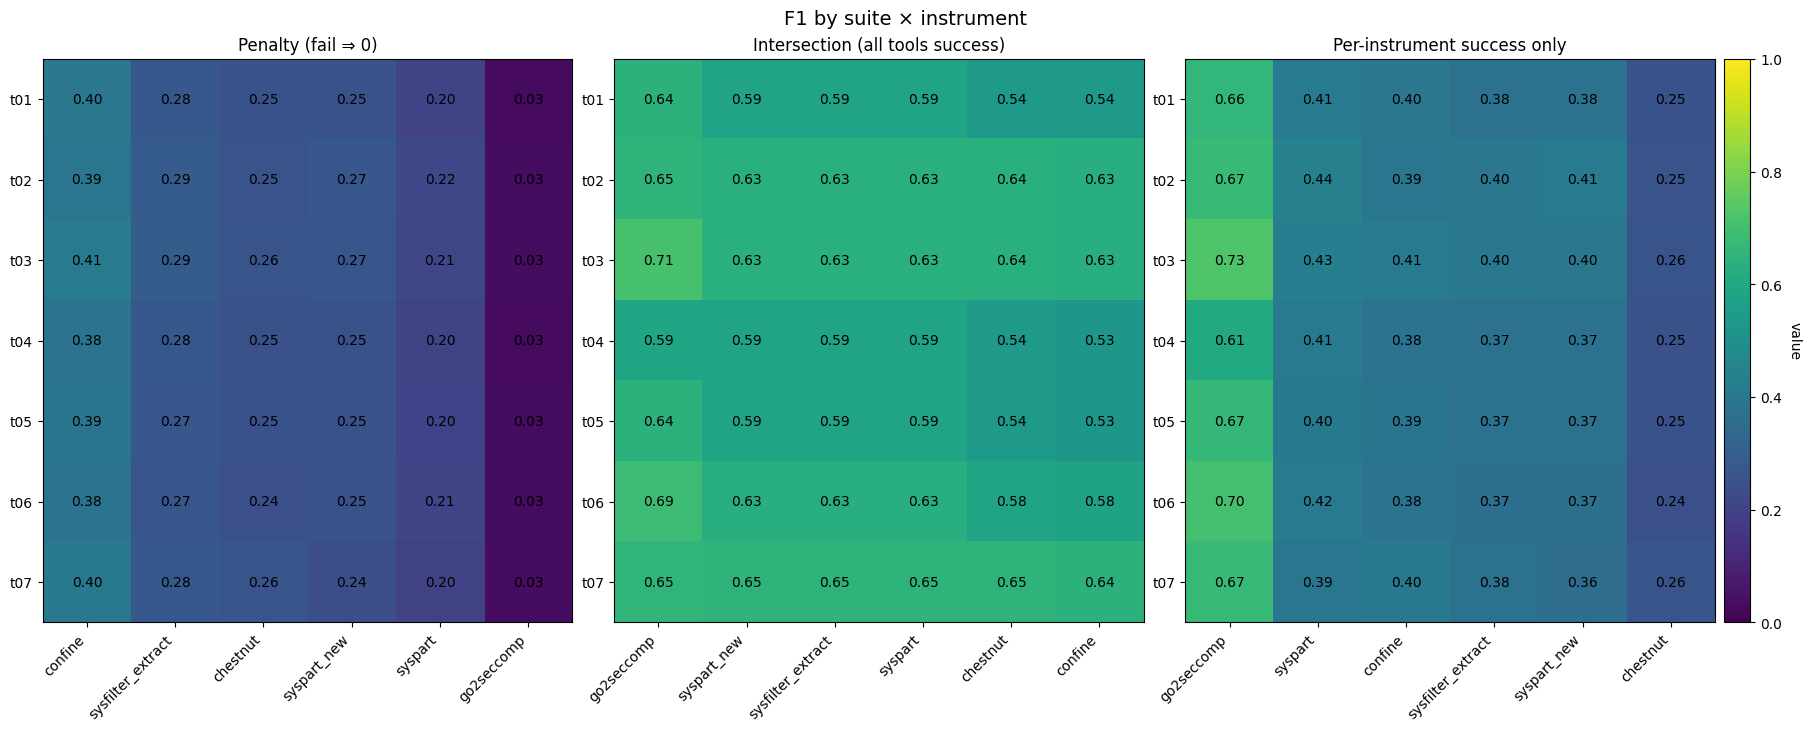

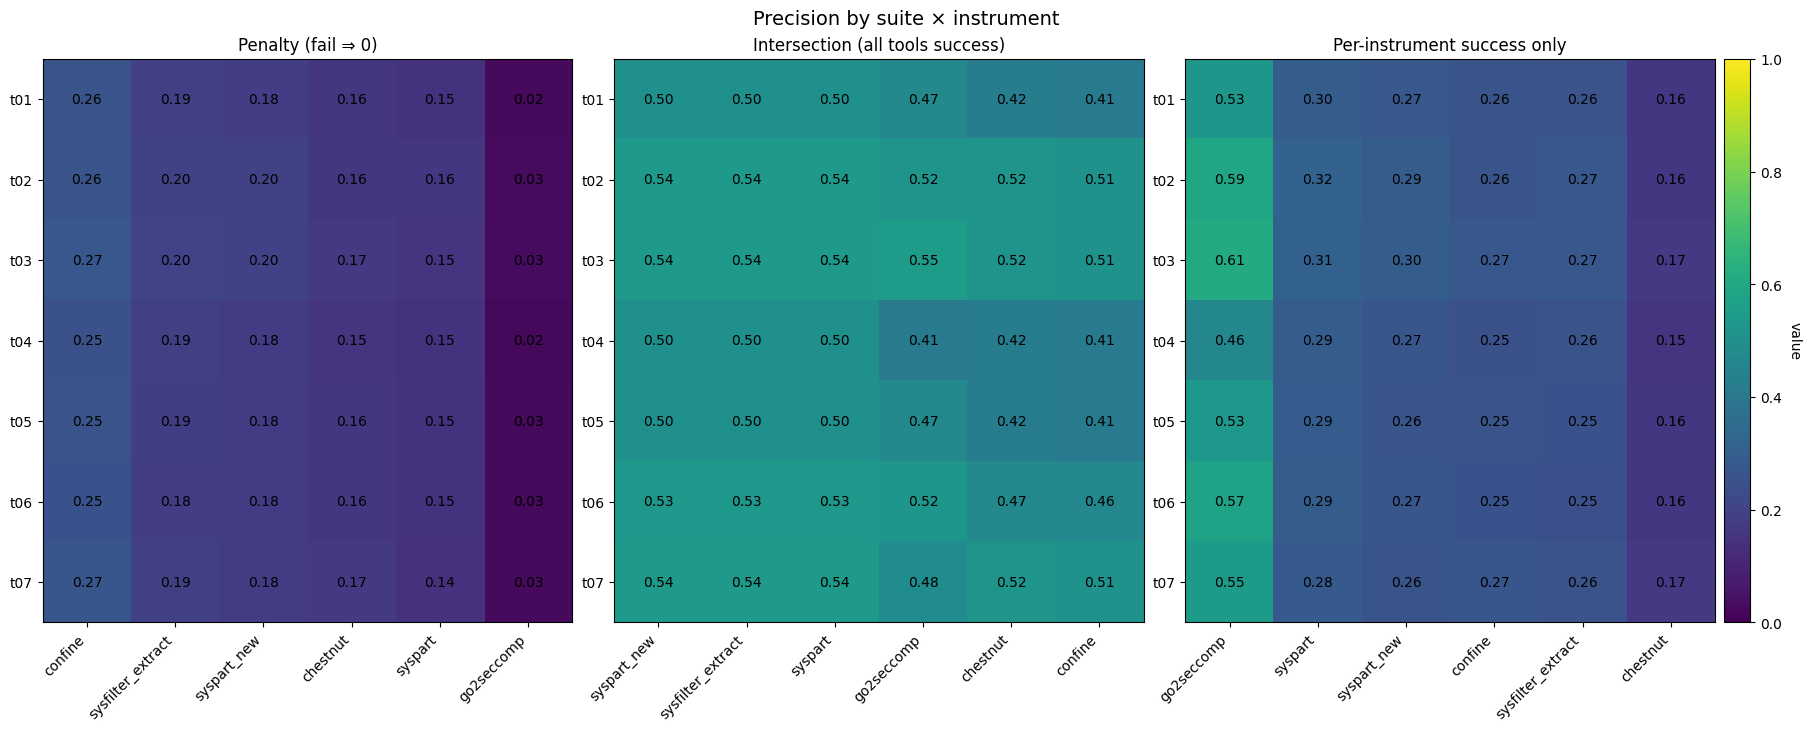

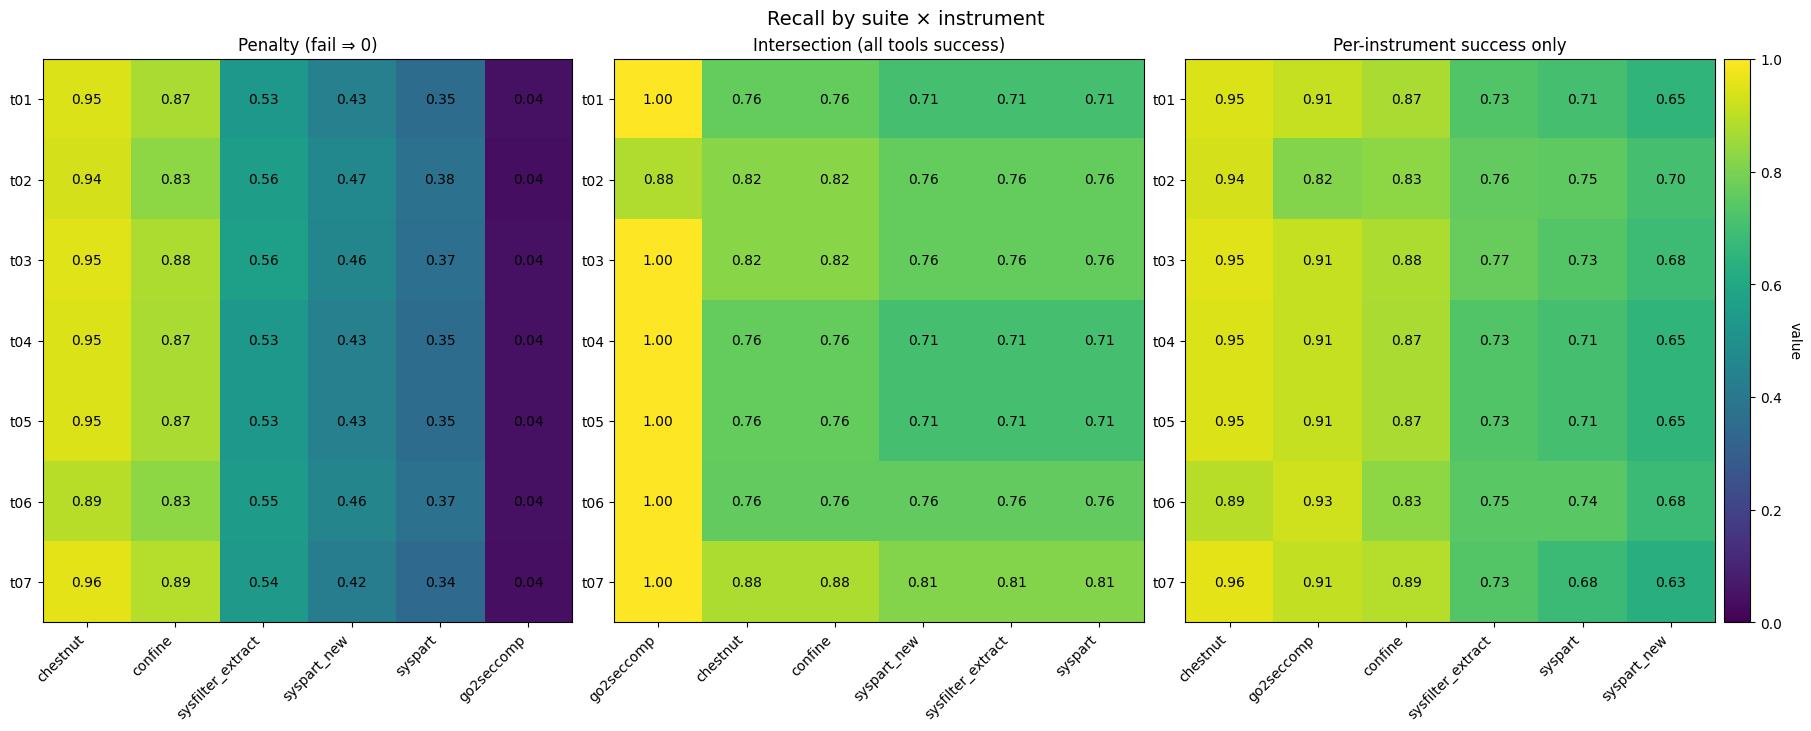

[lang] ['c', 'cpp', 'go', 'rust']


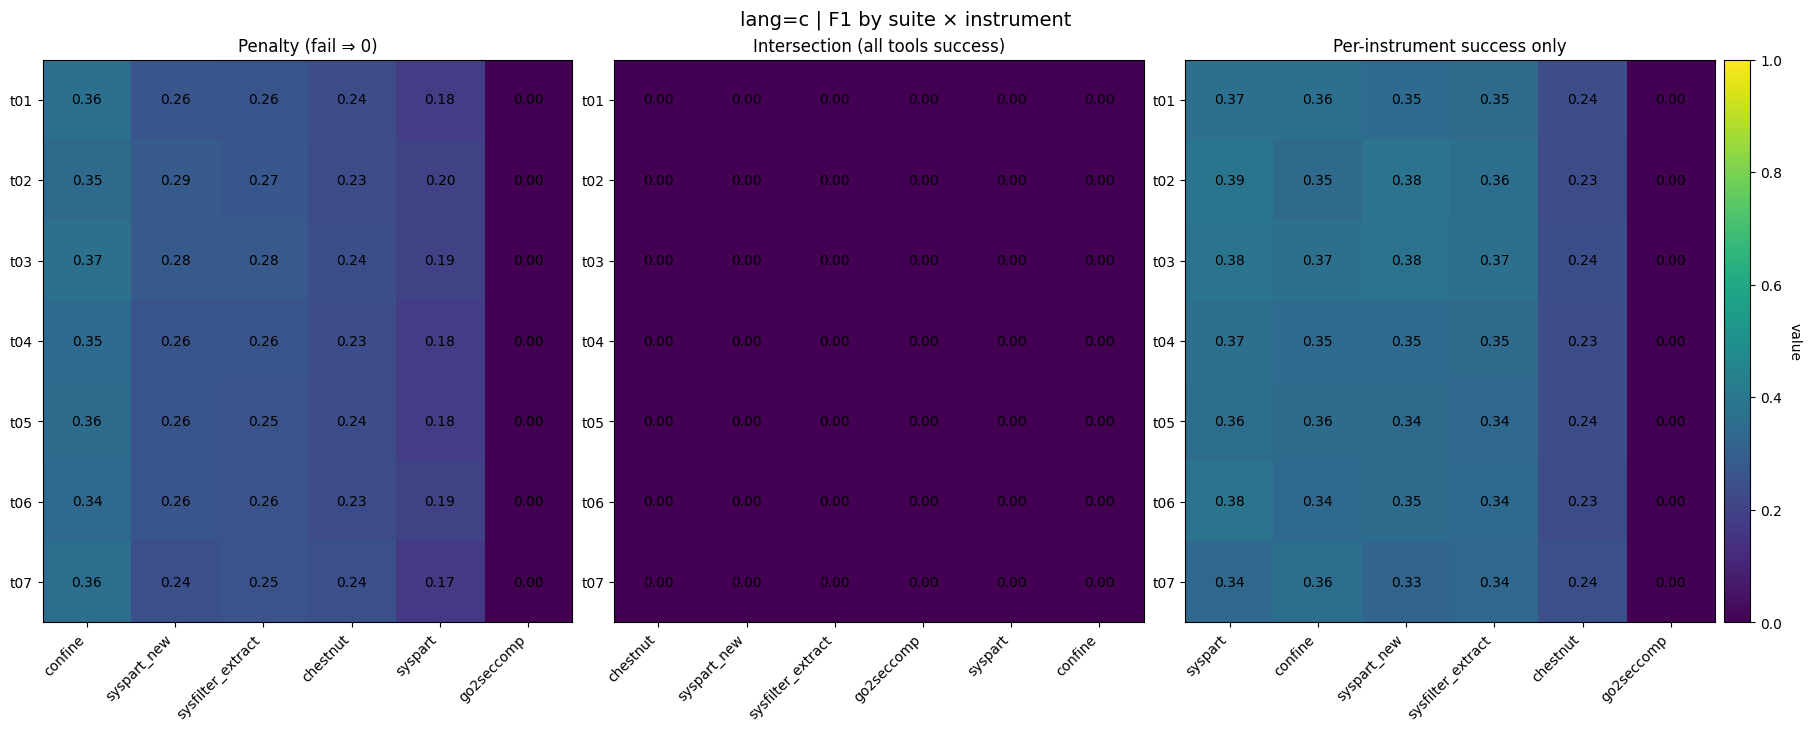

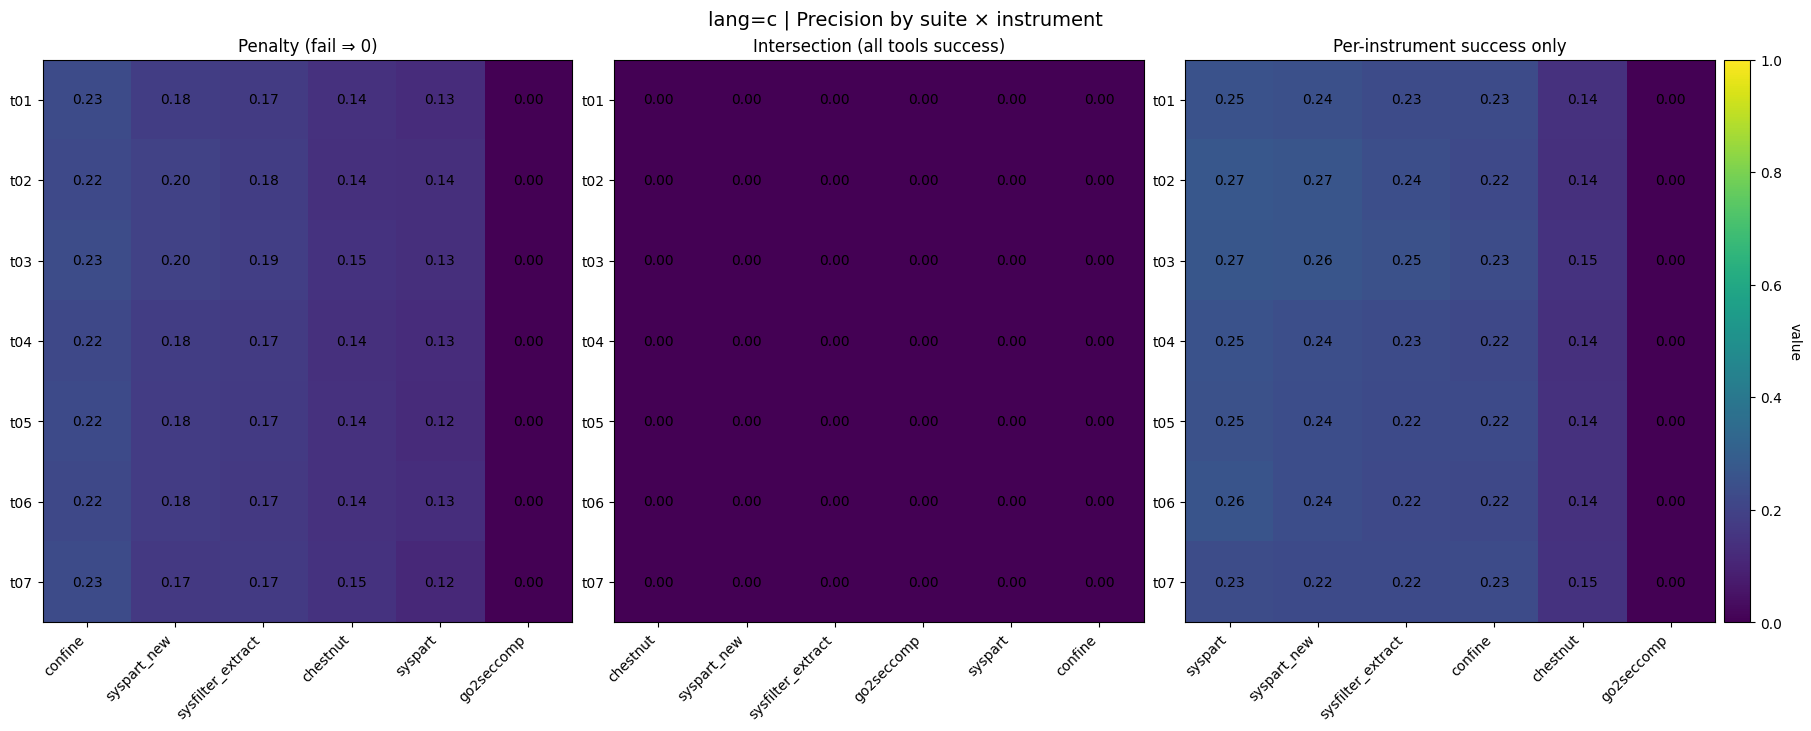

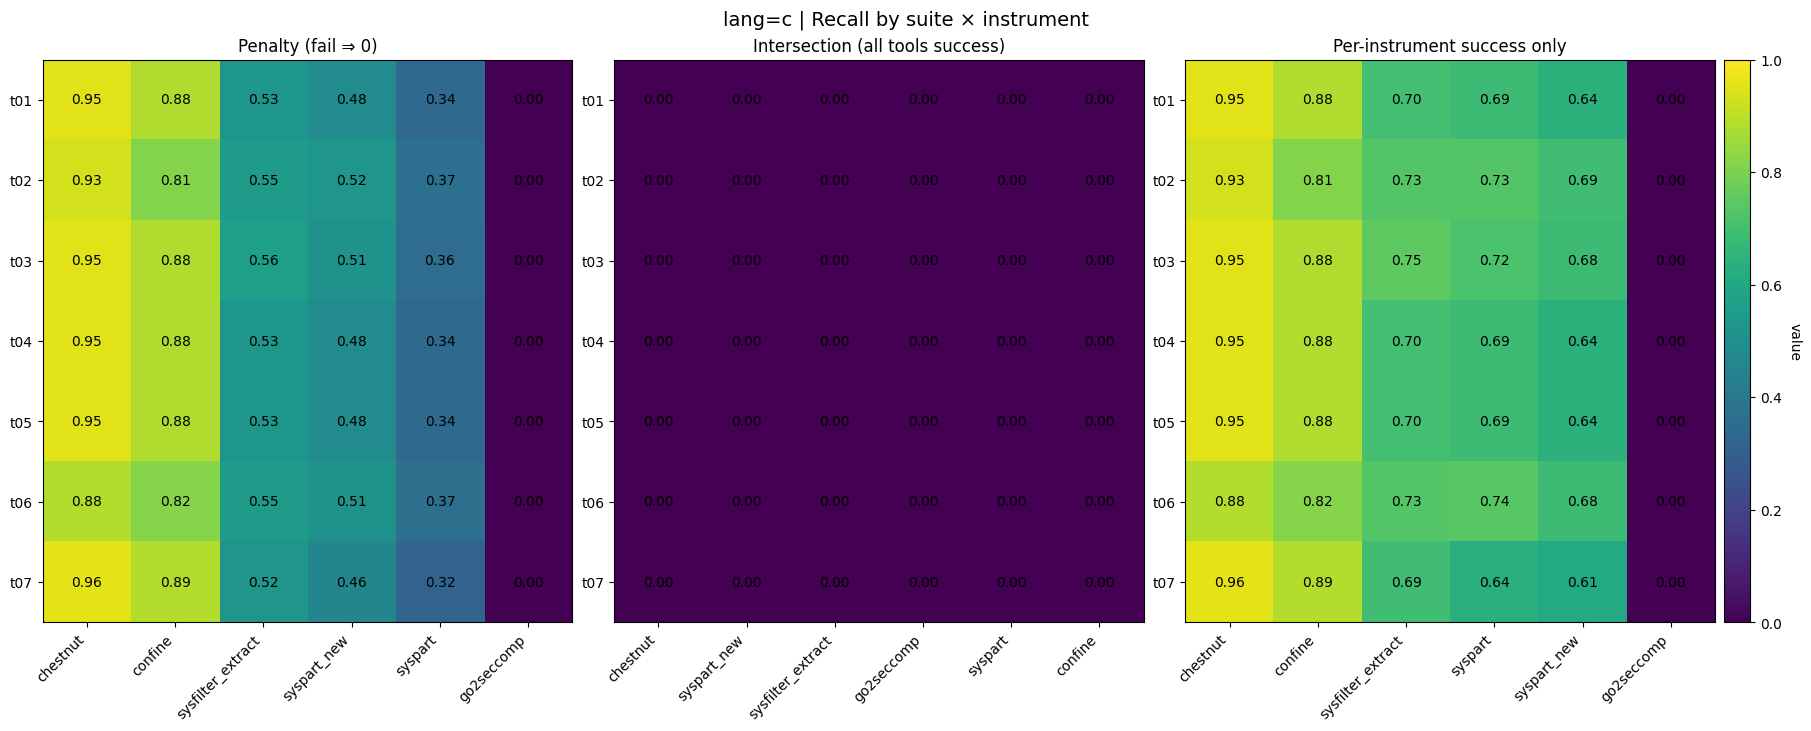

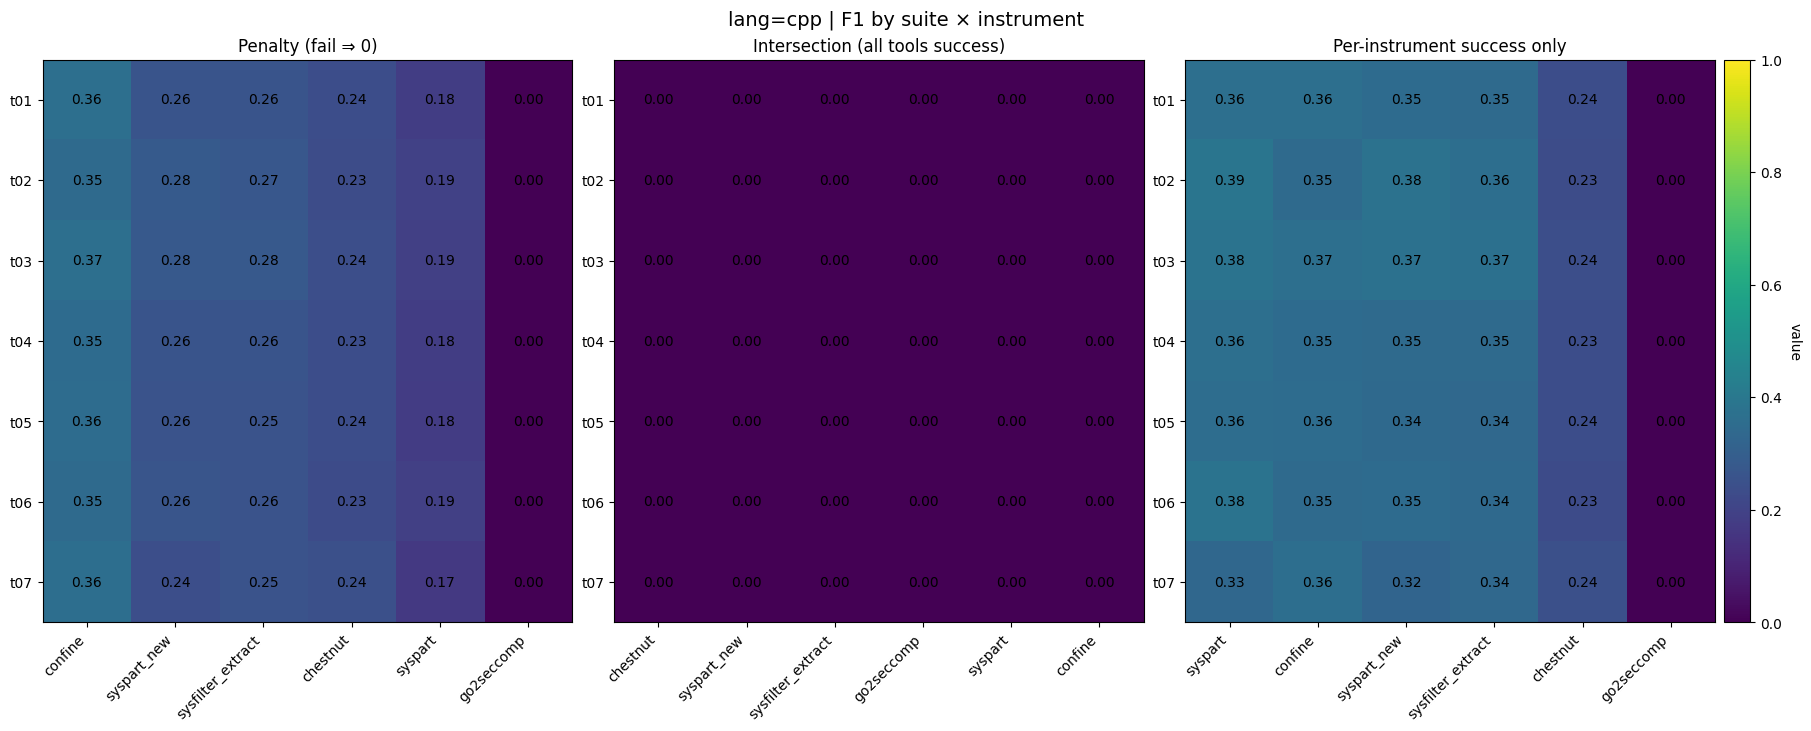

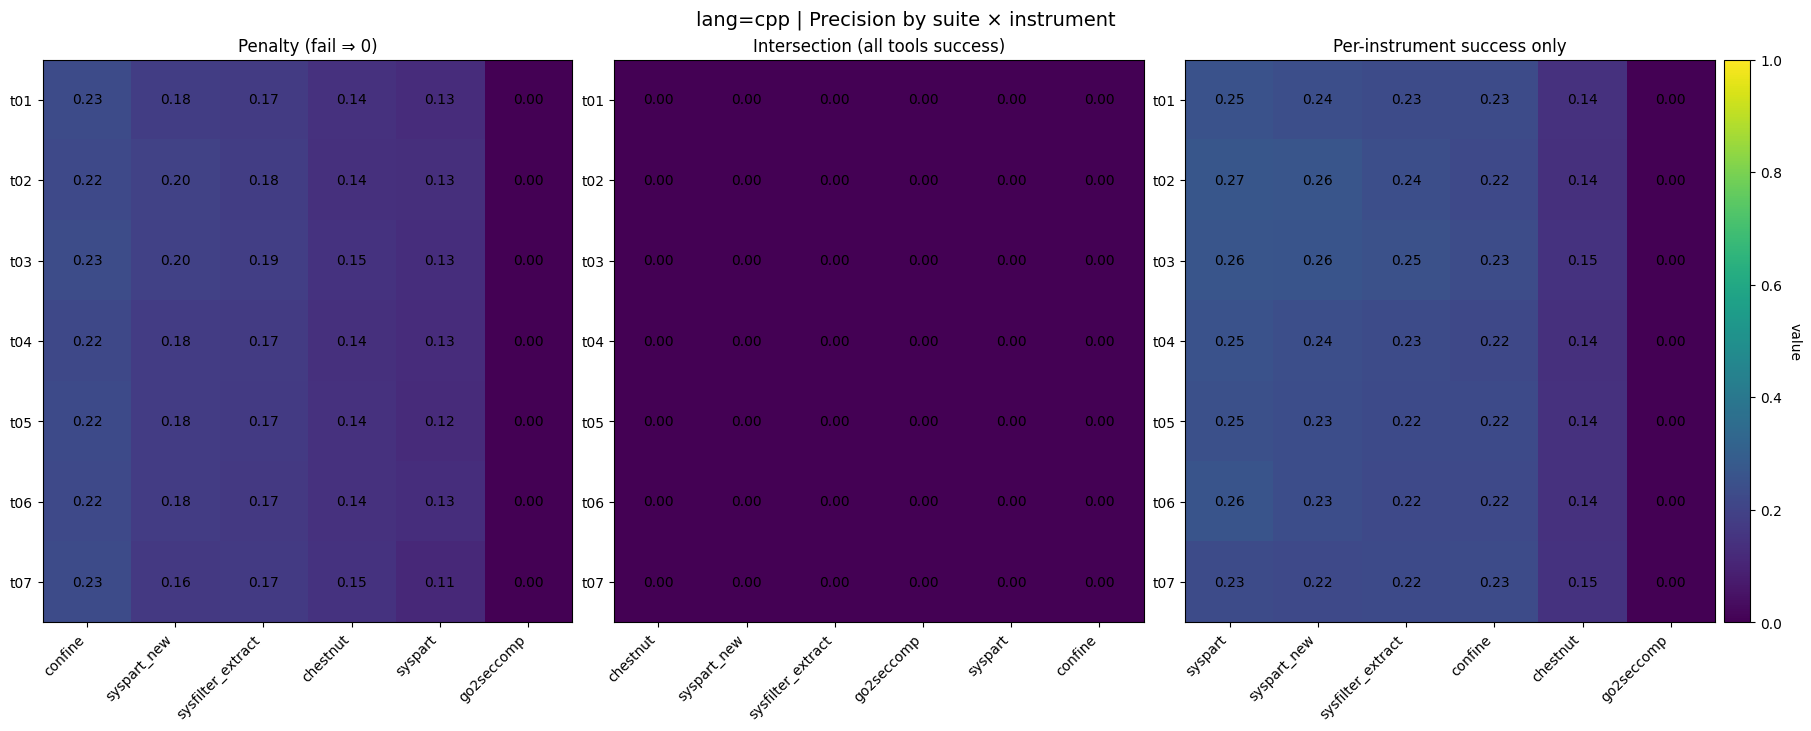

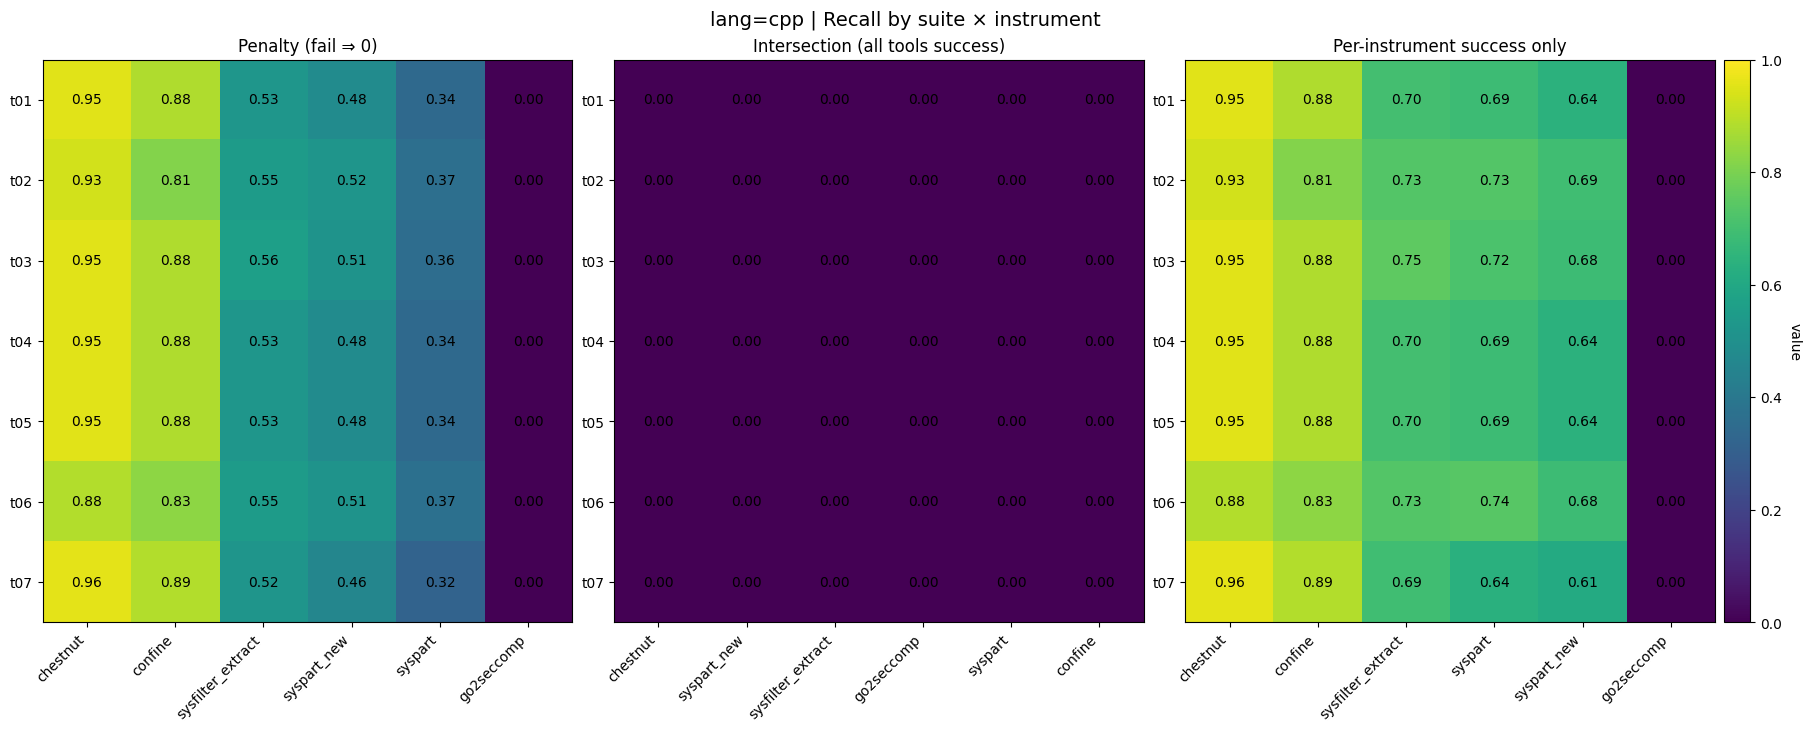

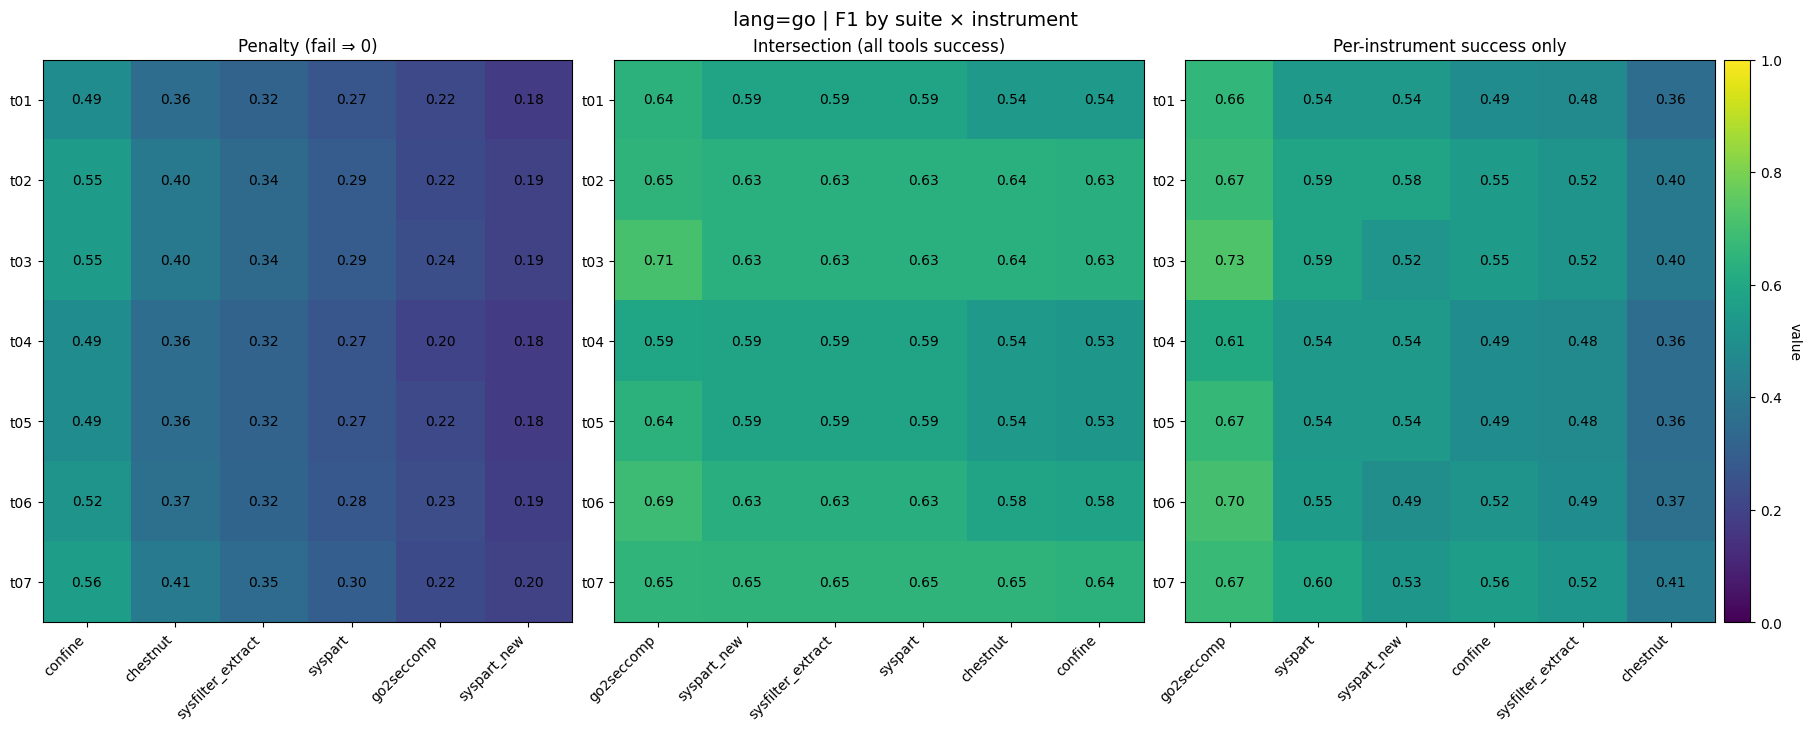

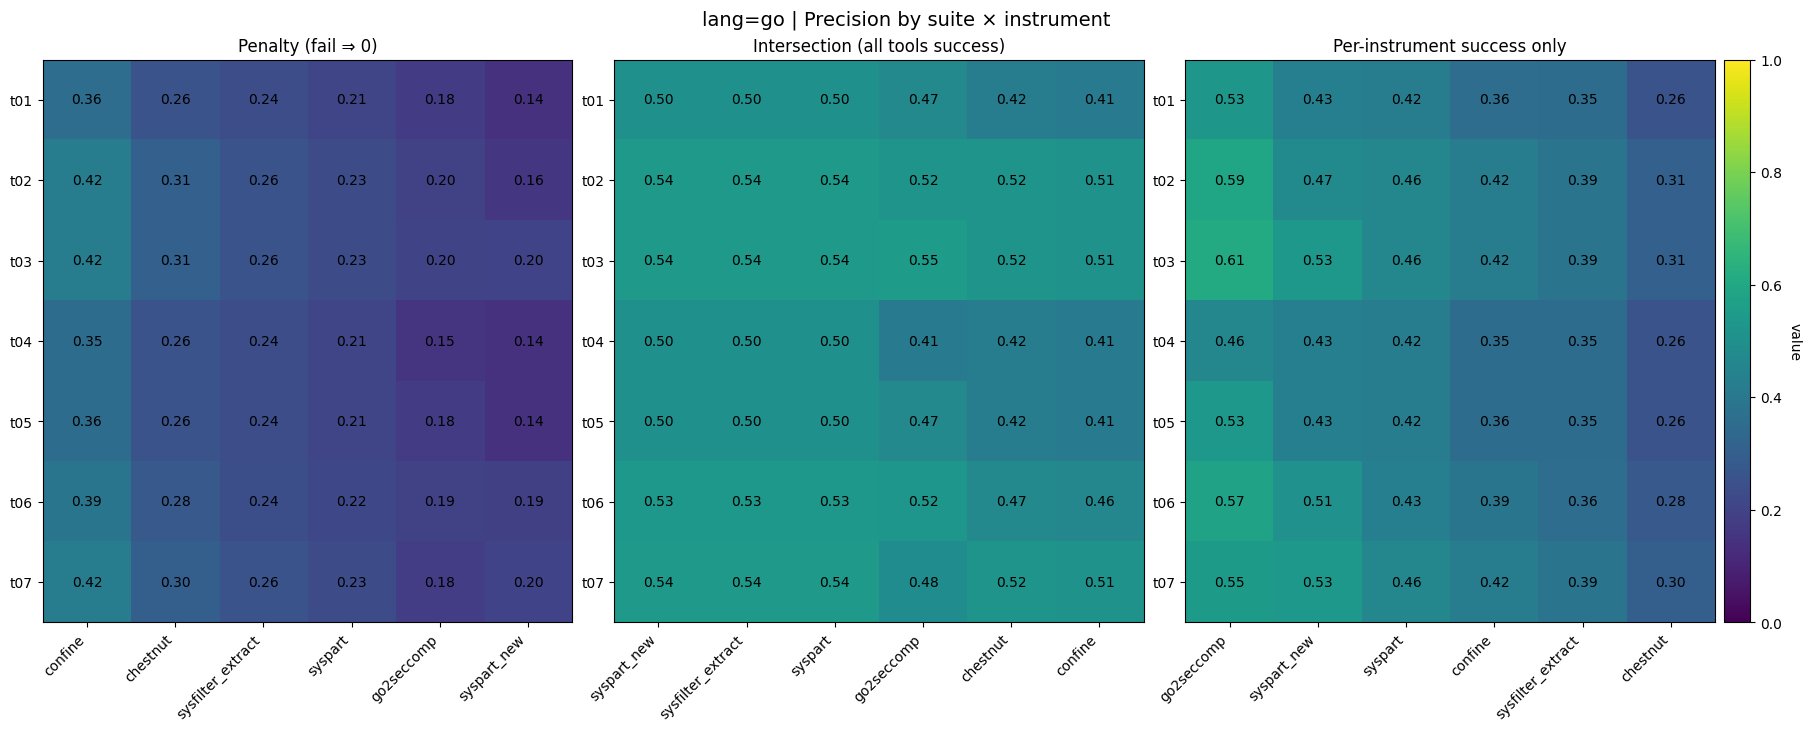

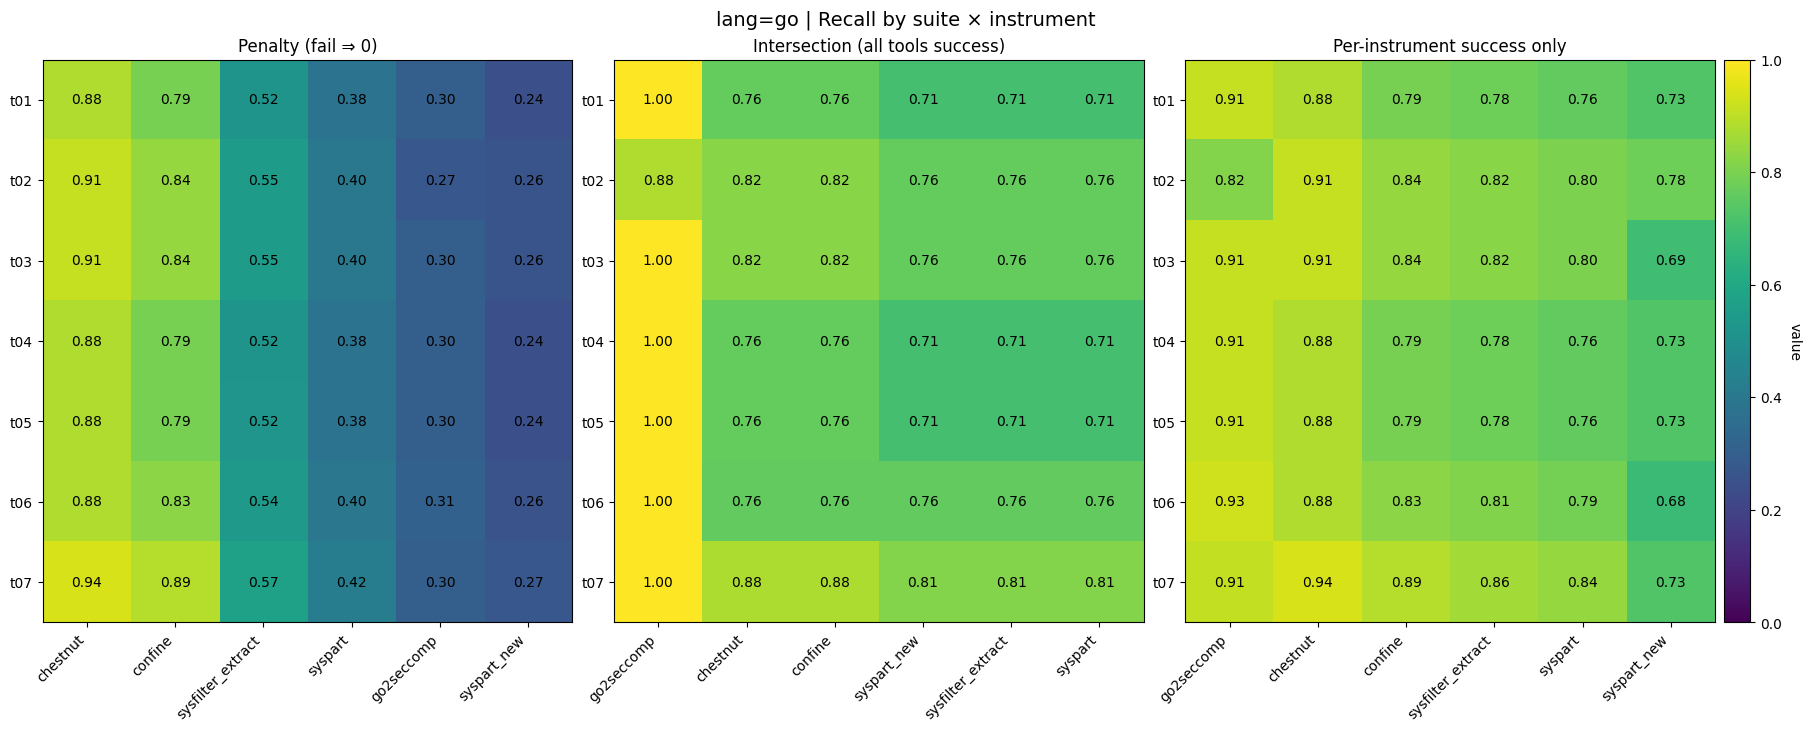

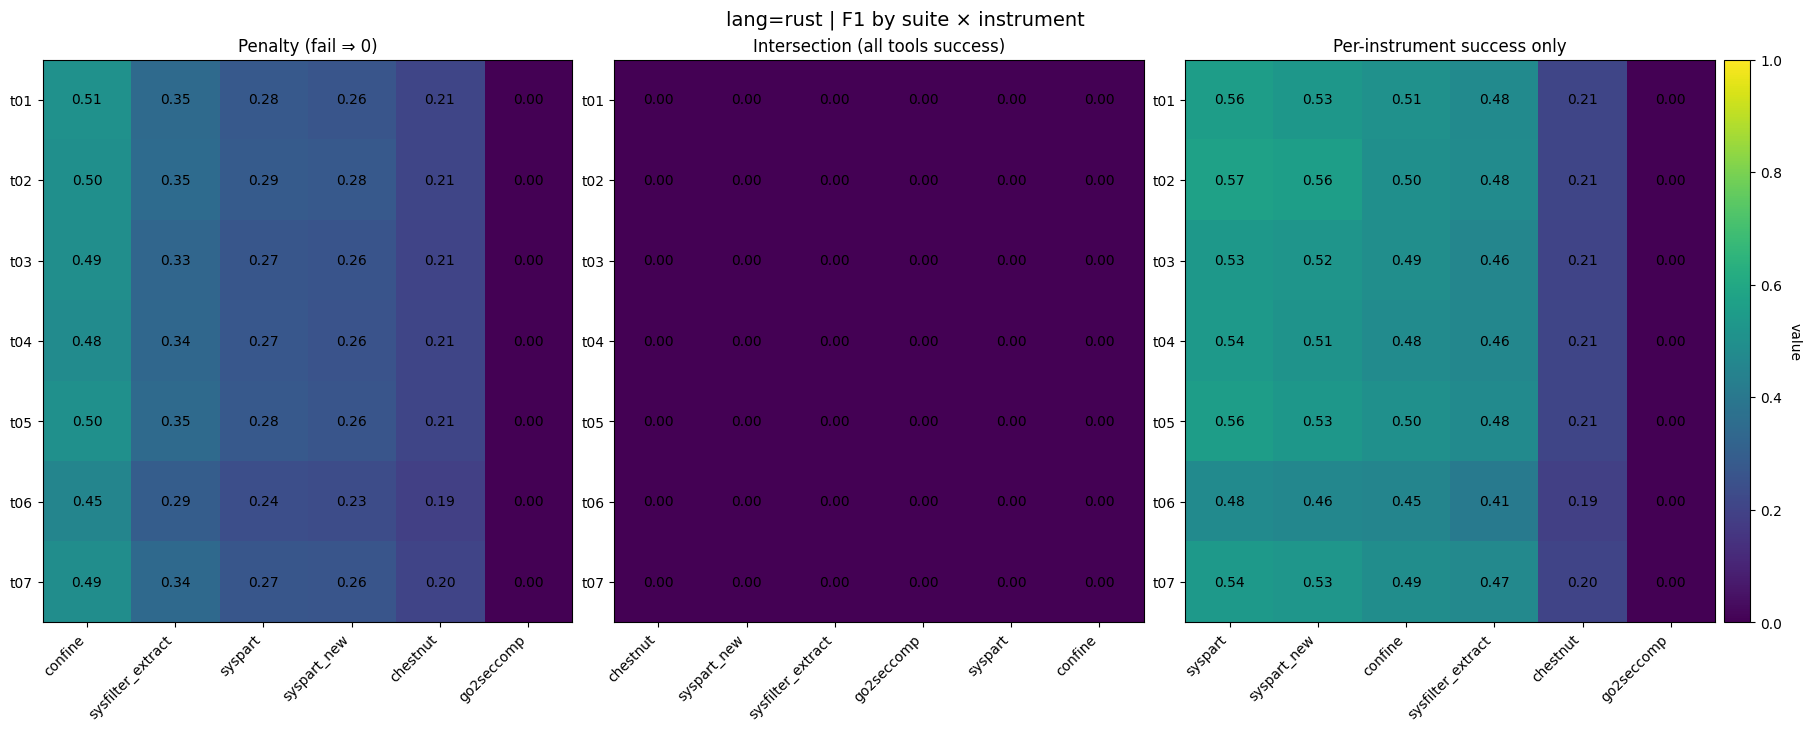

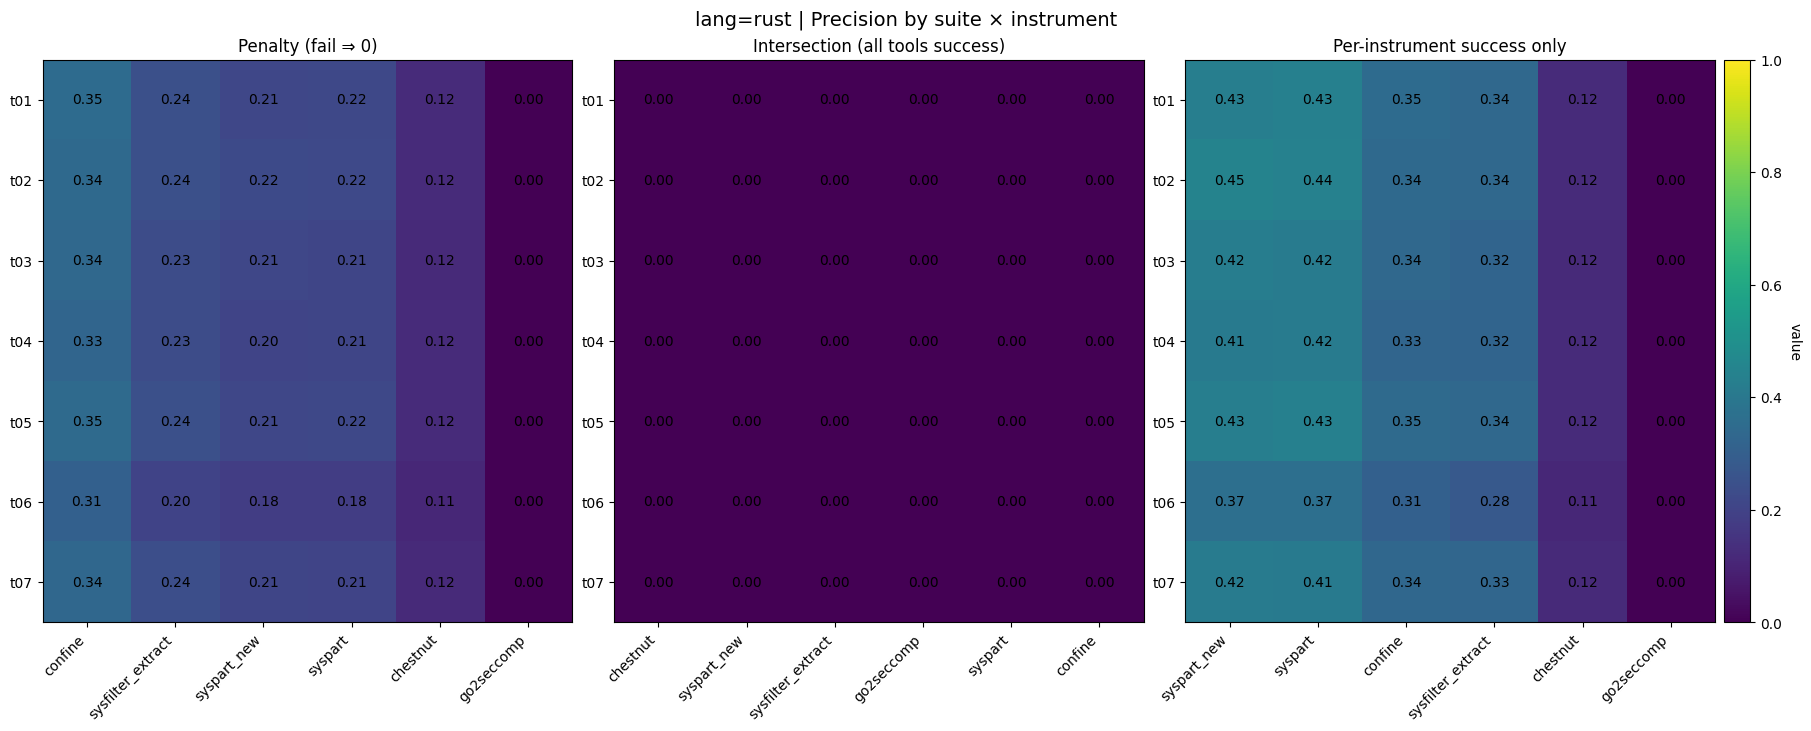

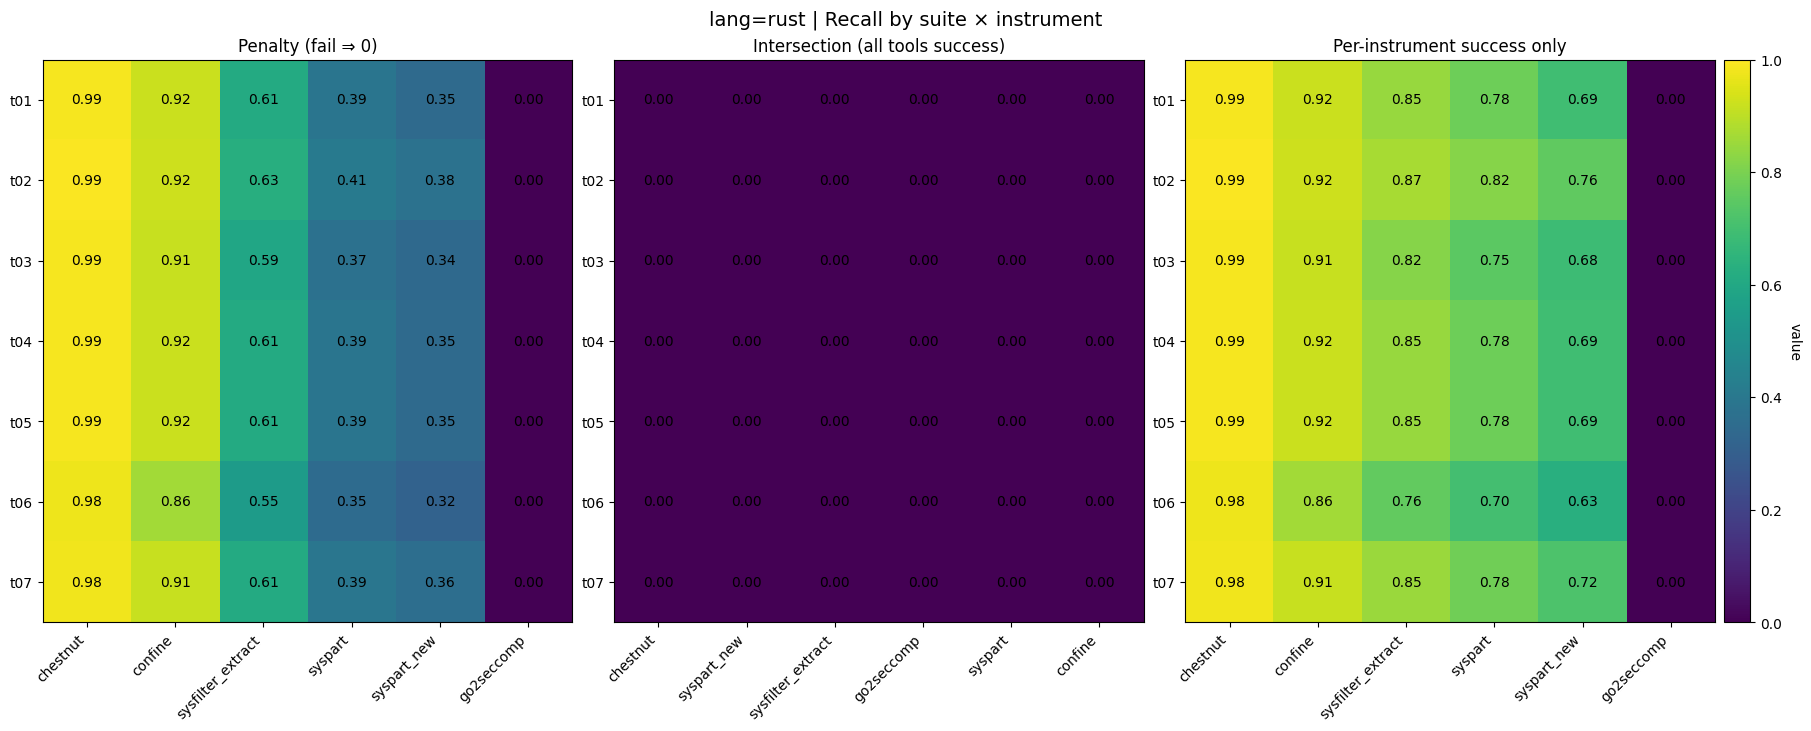

[strip] ['nostrip']


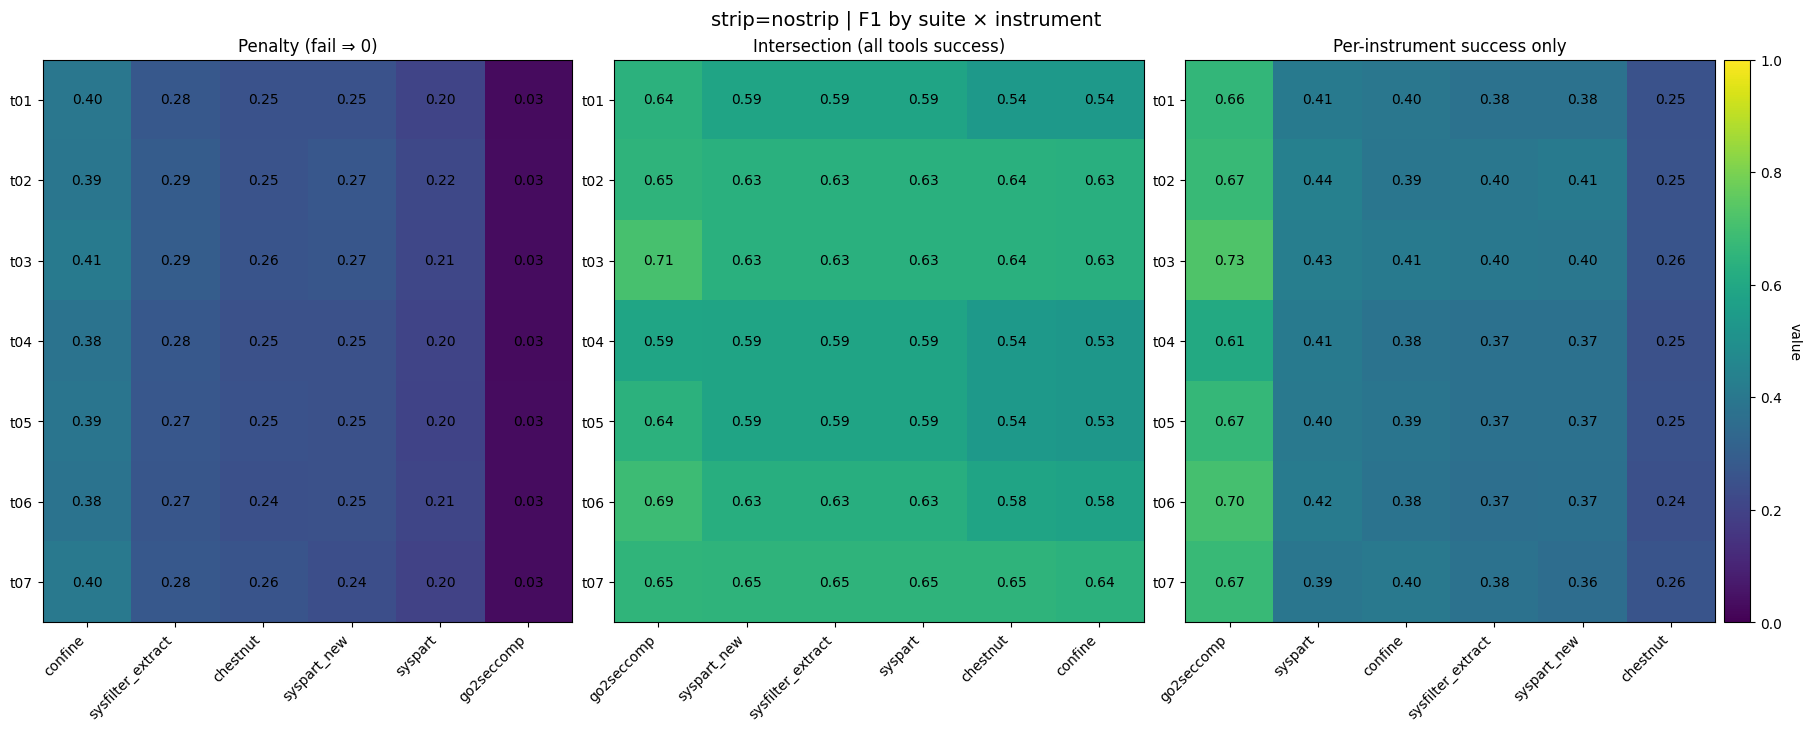

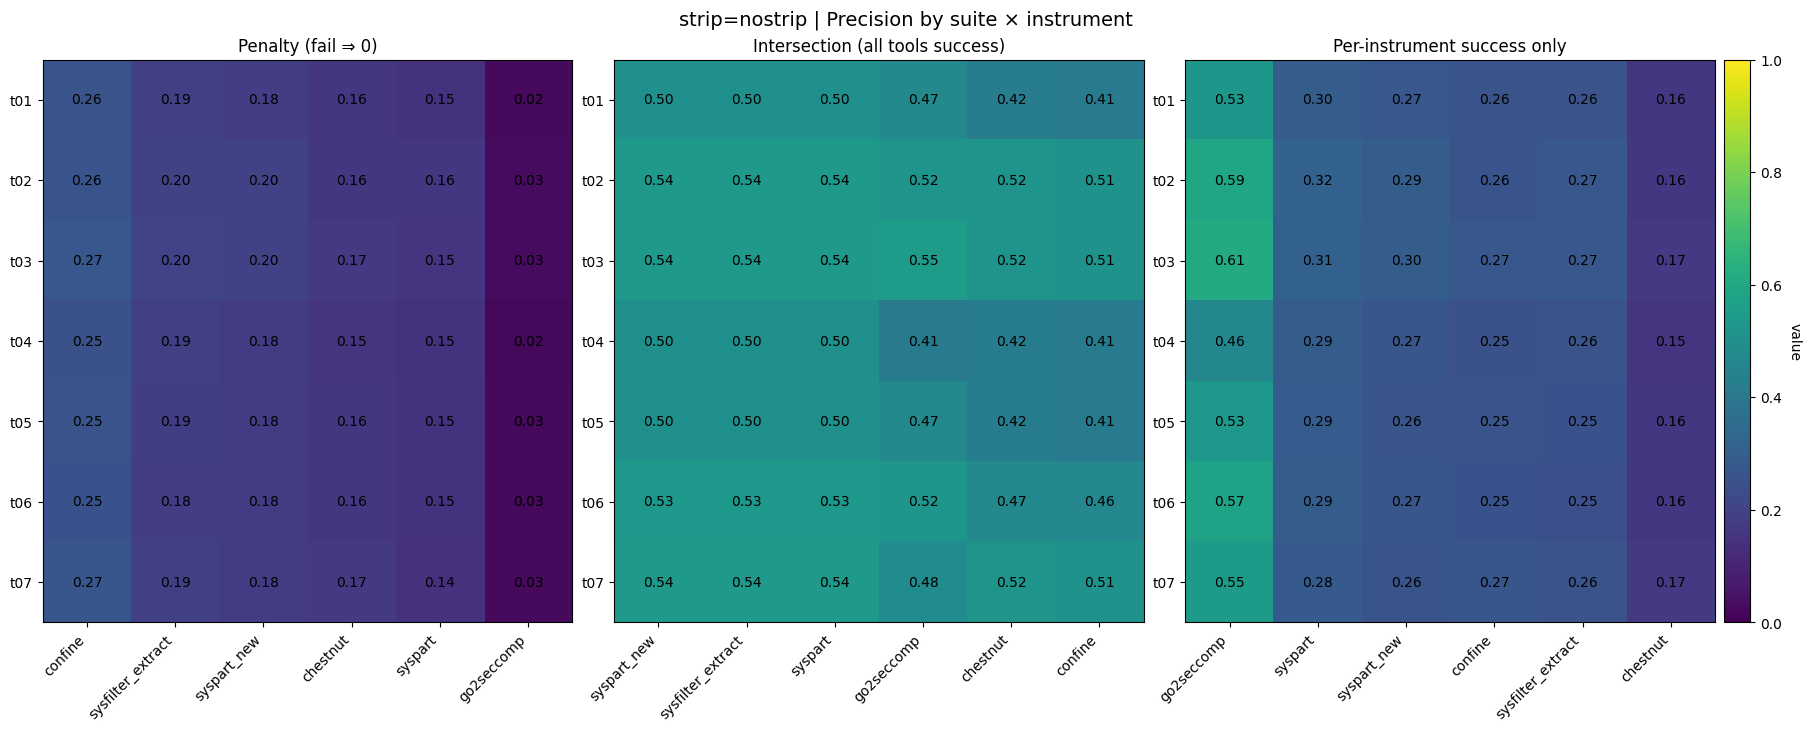

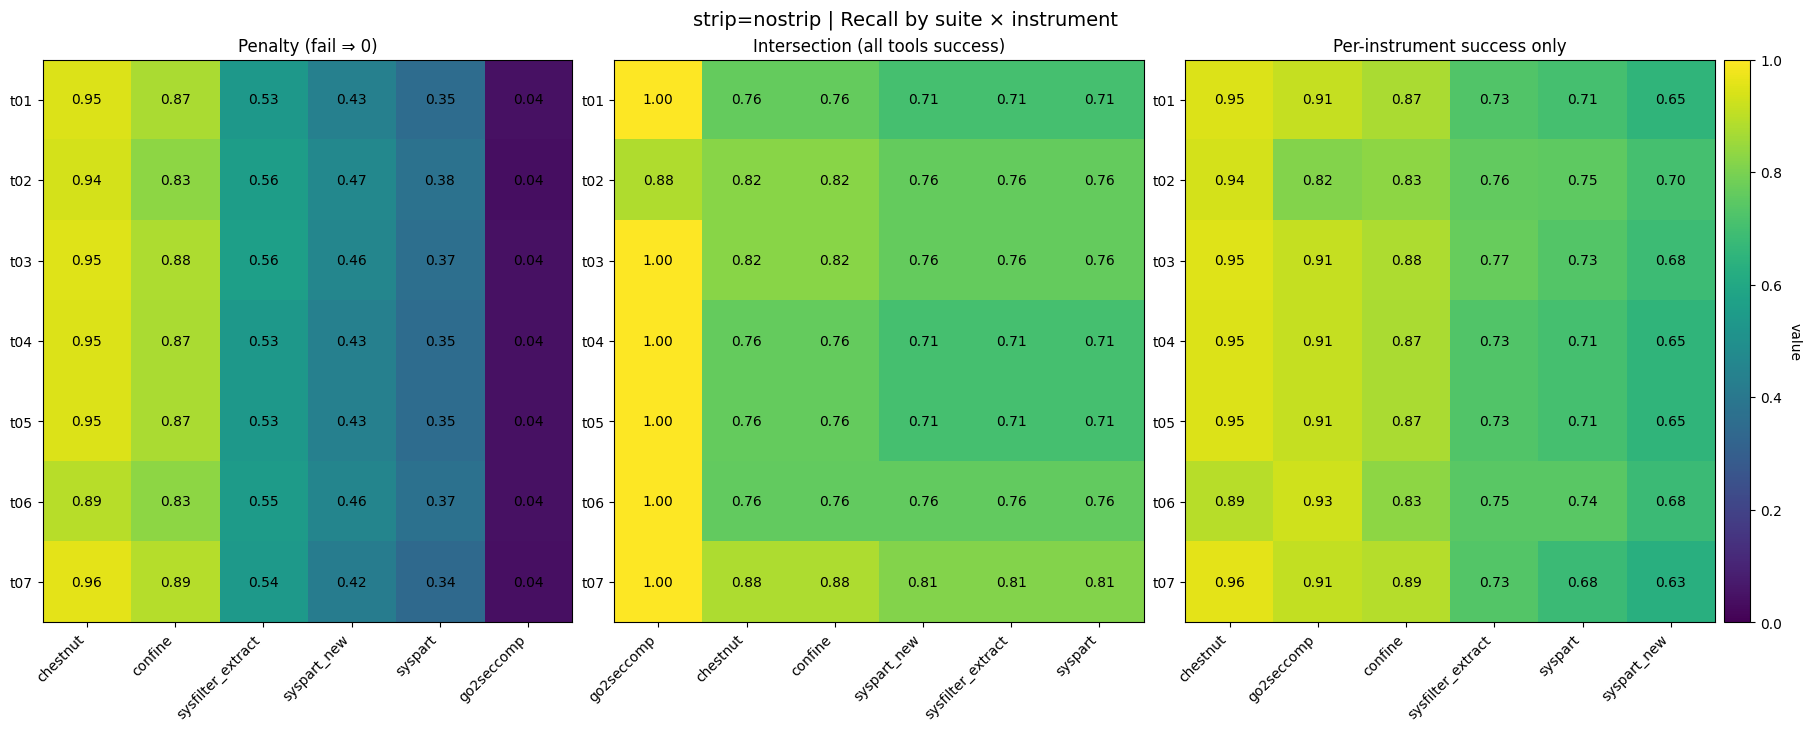

[pie_mode] ['nopie', 'pie']


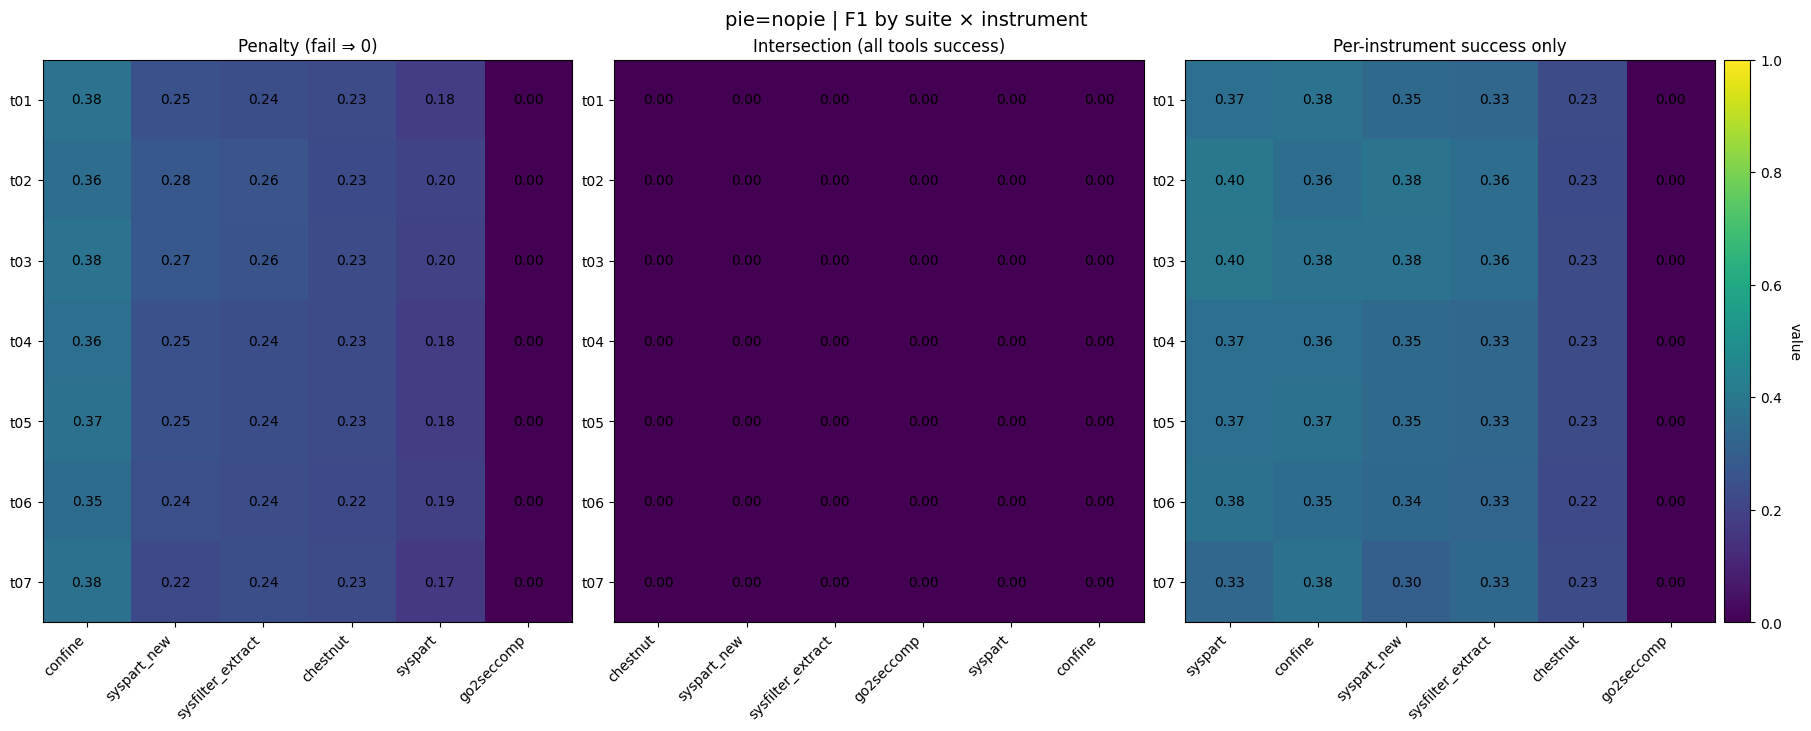

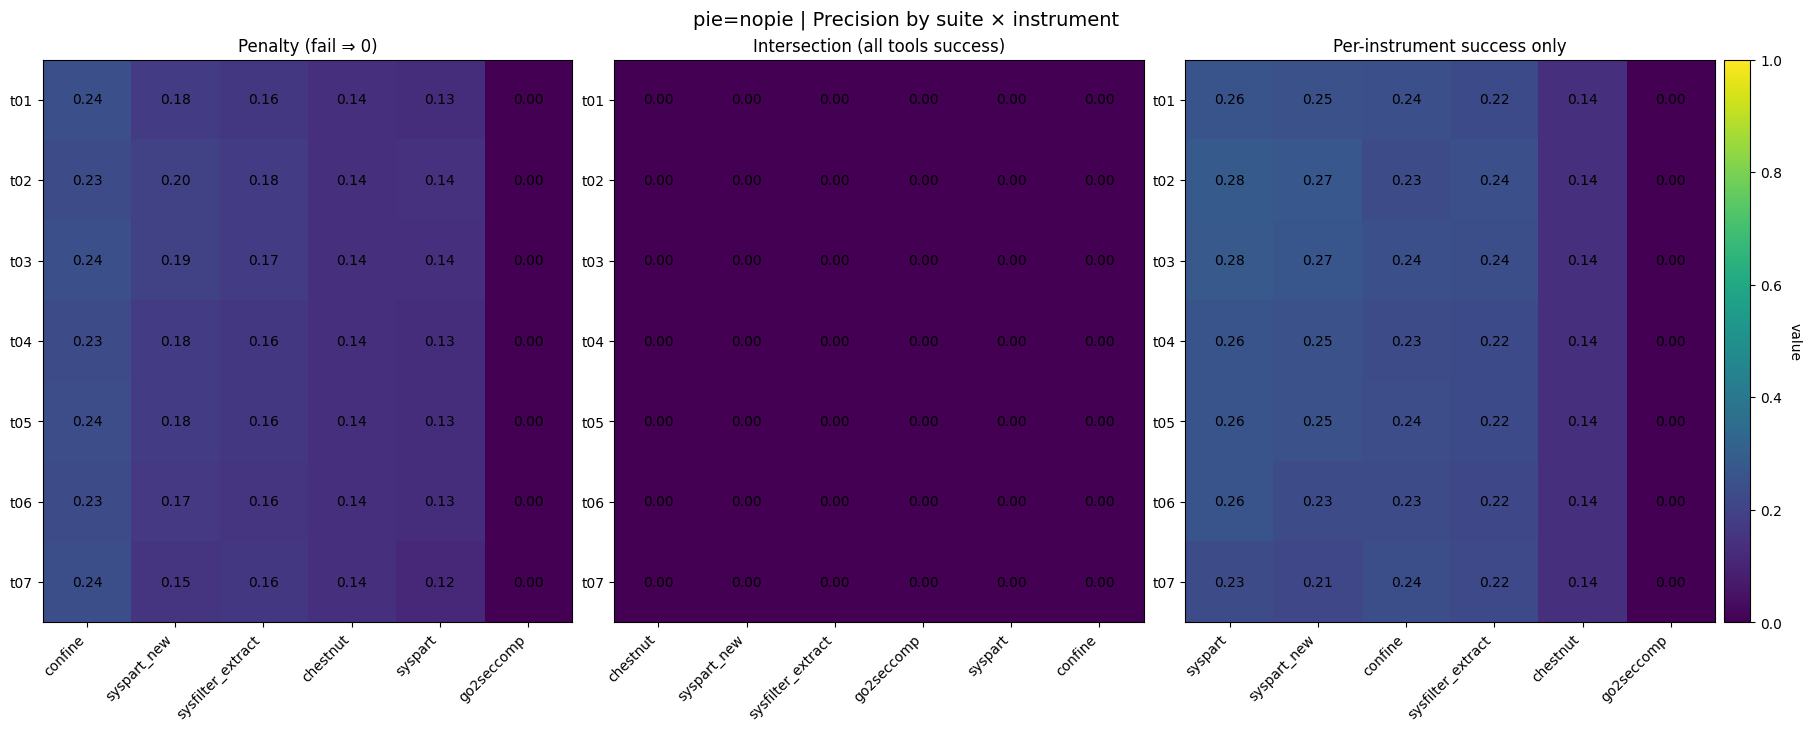

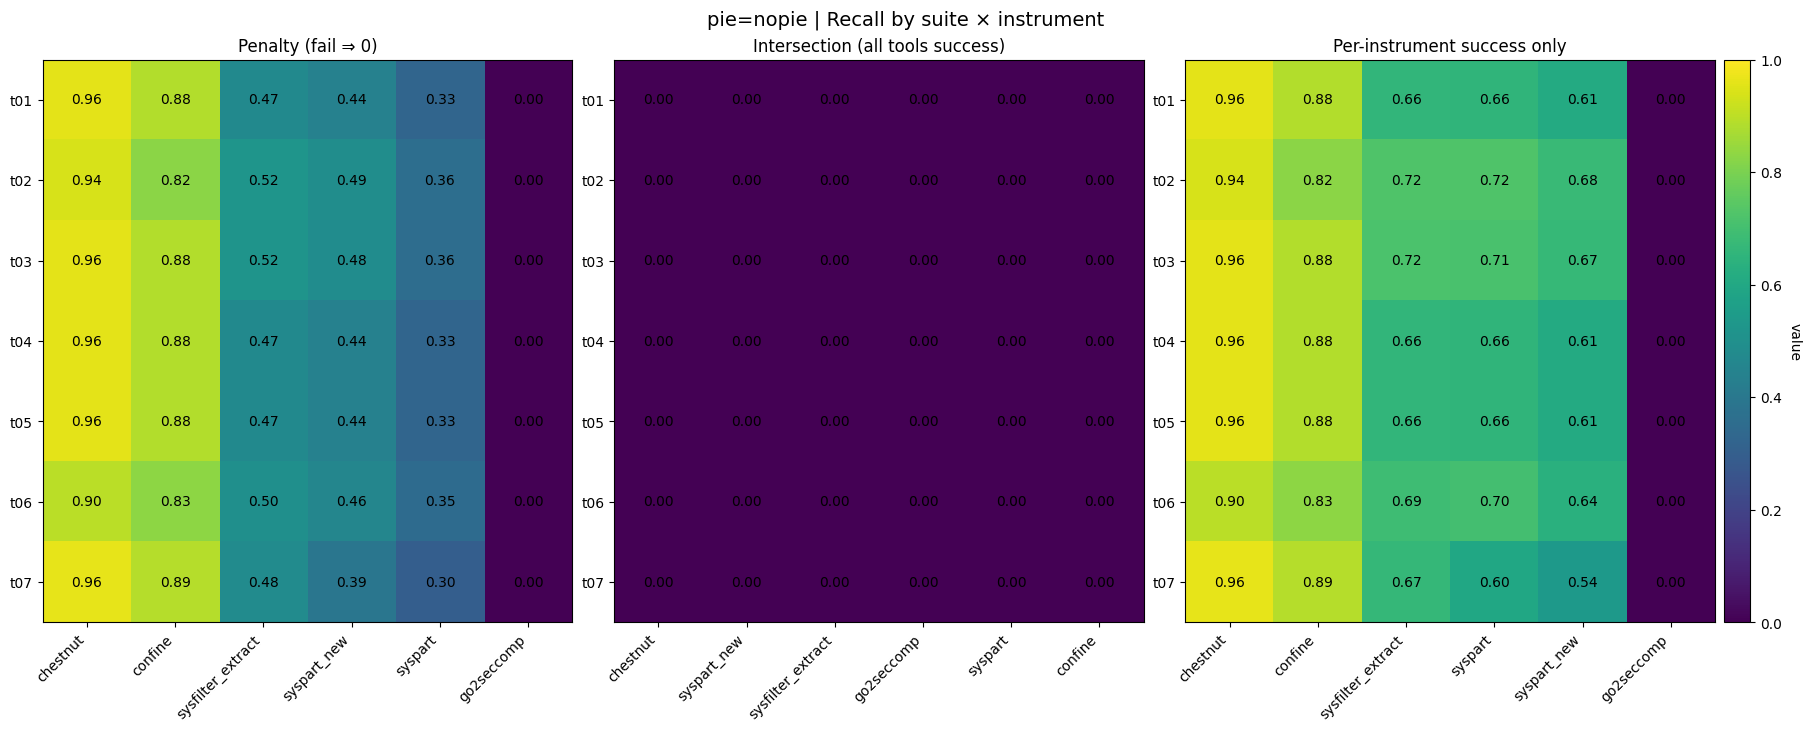

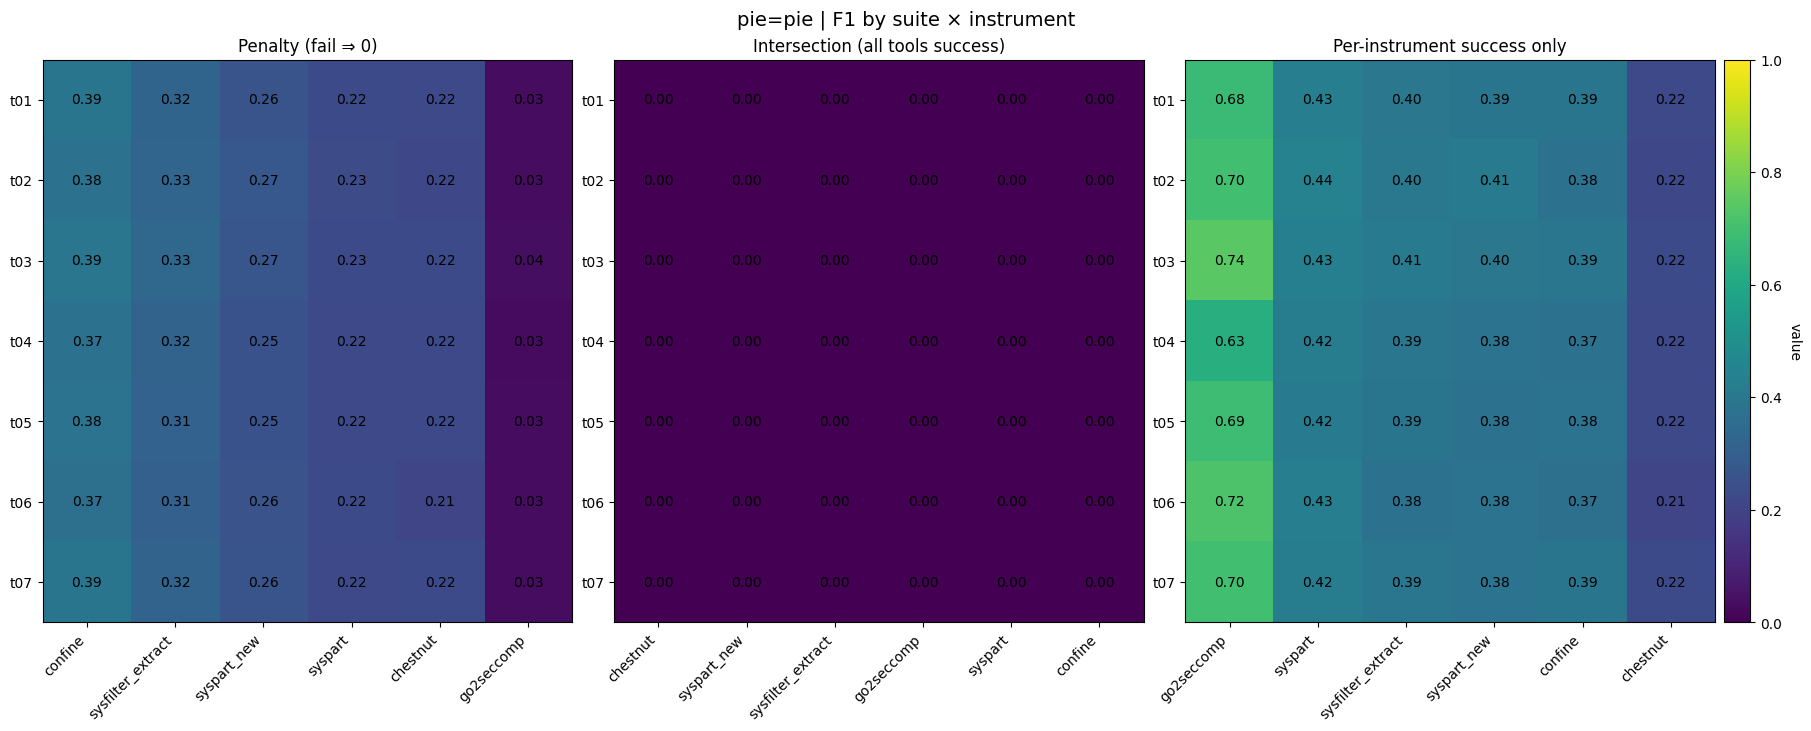

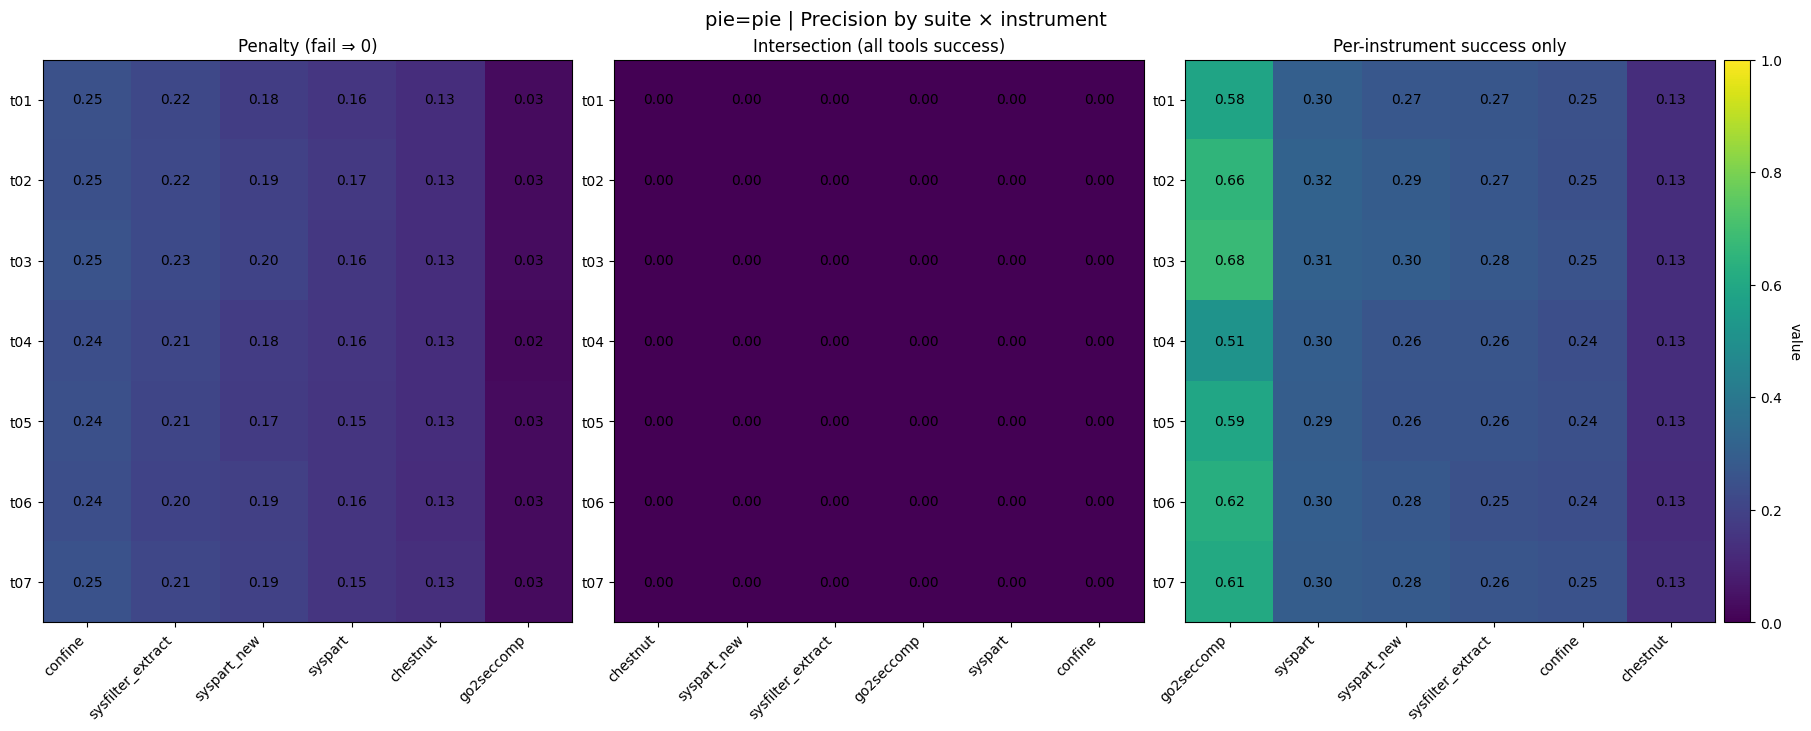

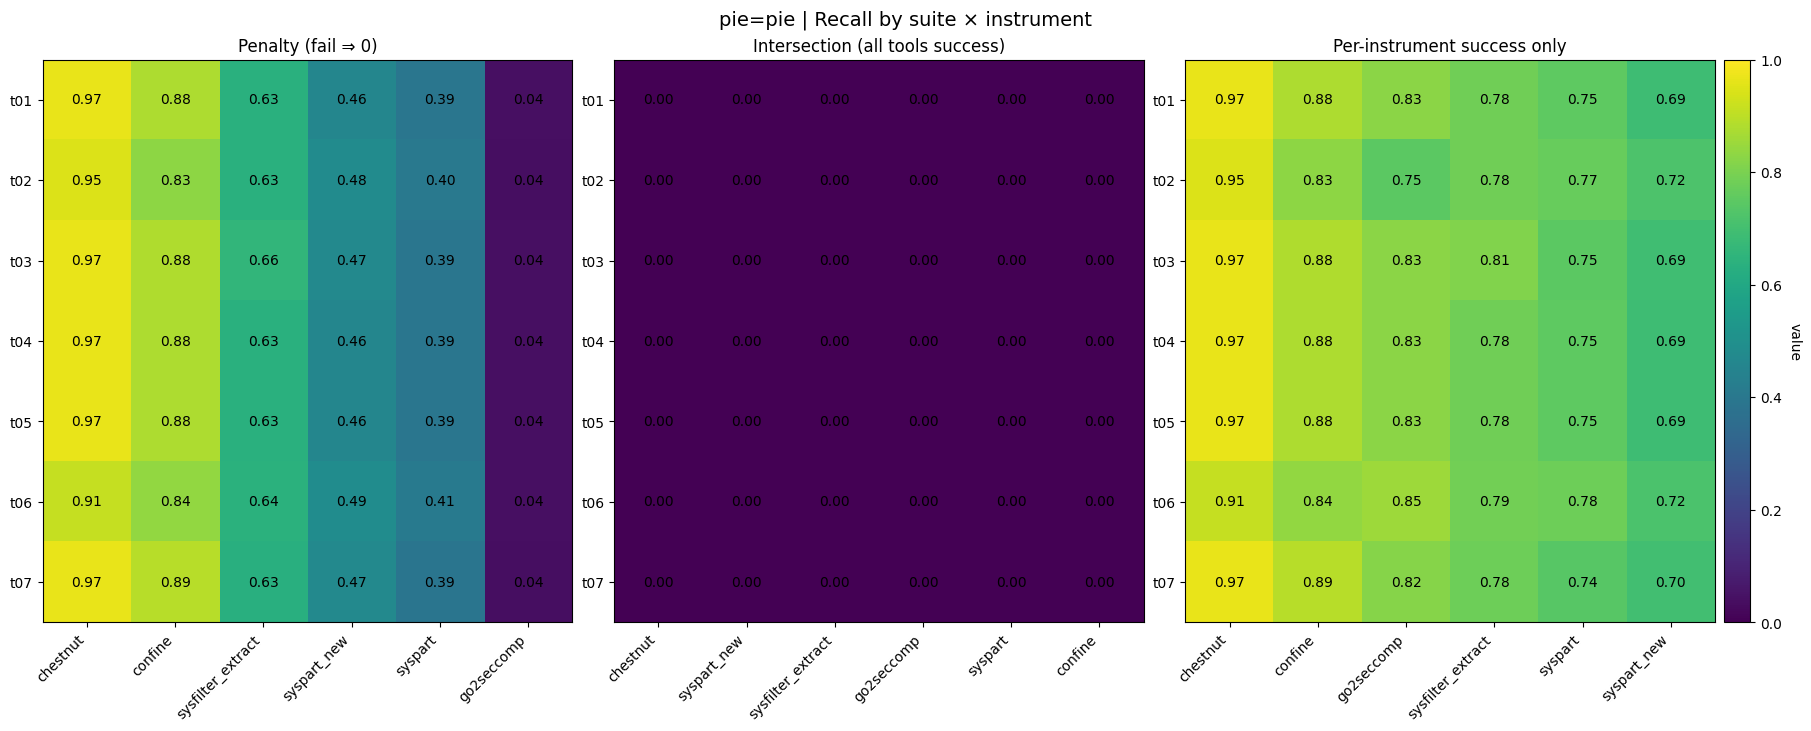

[lto_mode] ['lto', 'nolto']


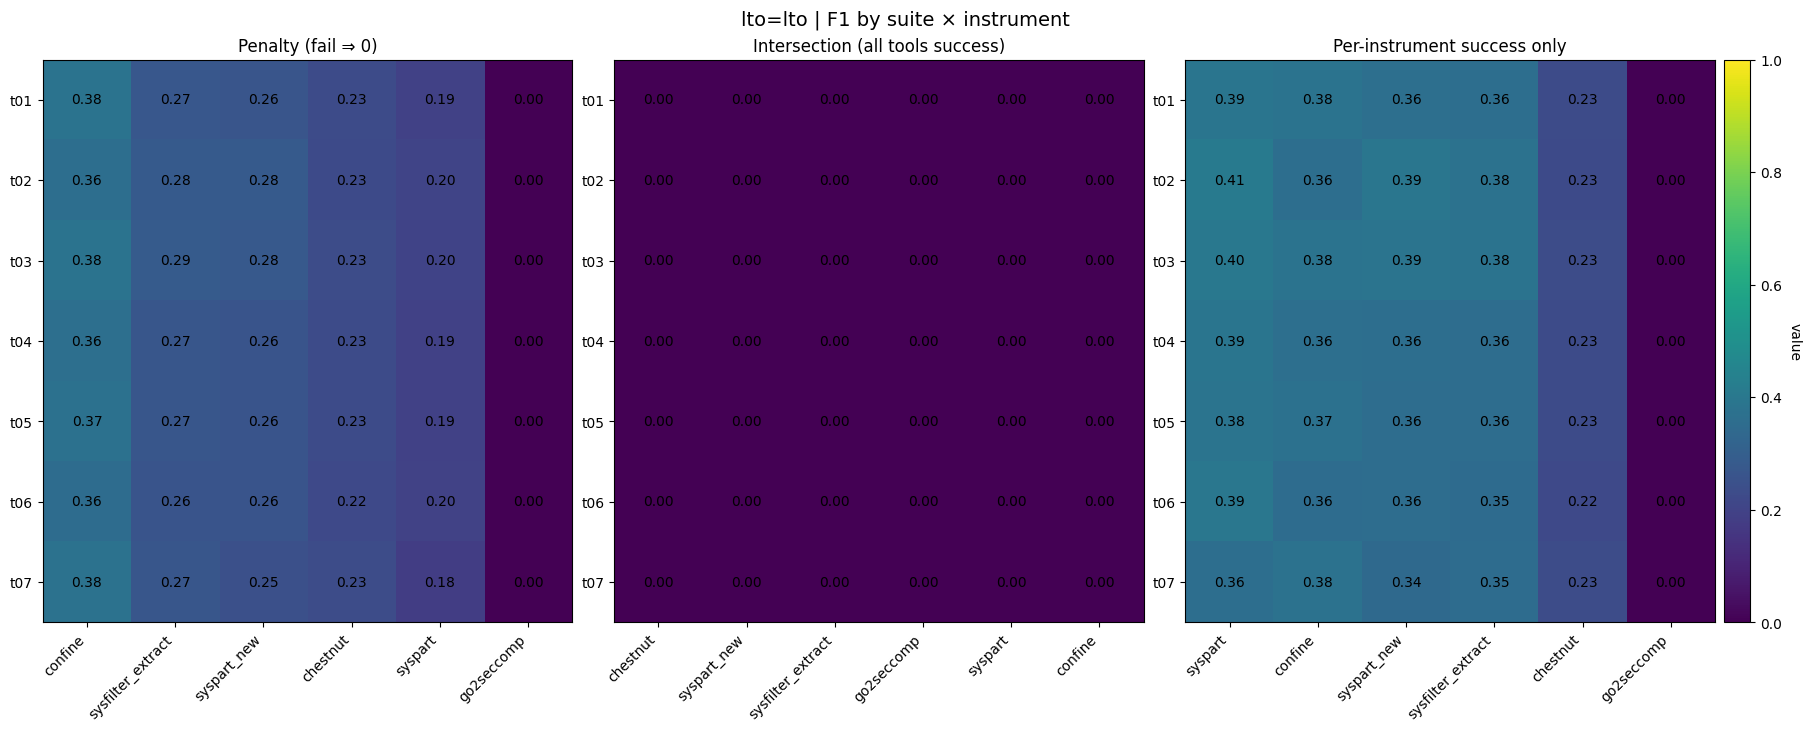

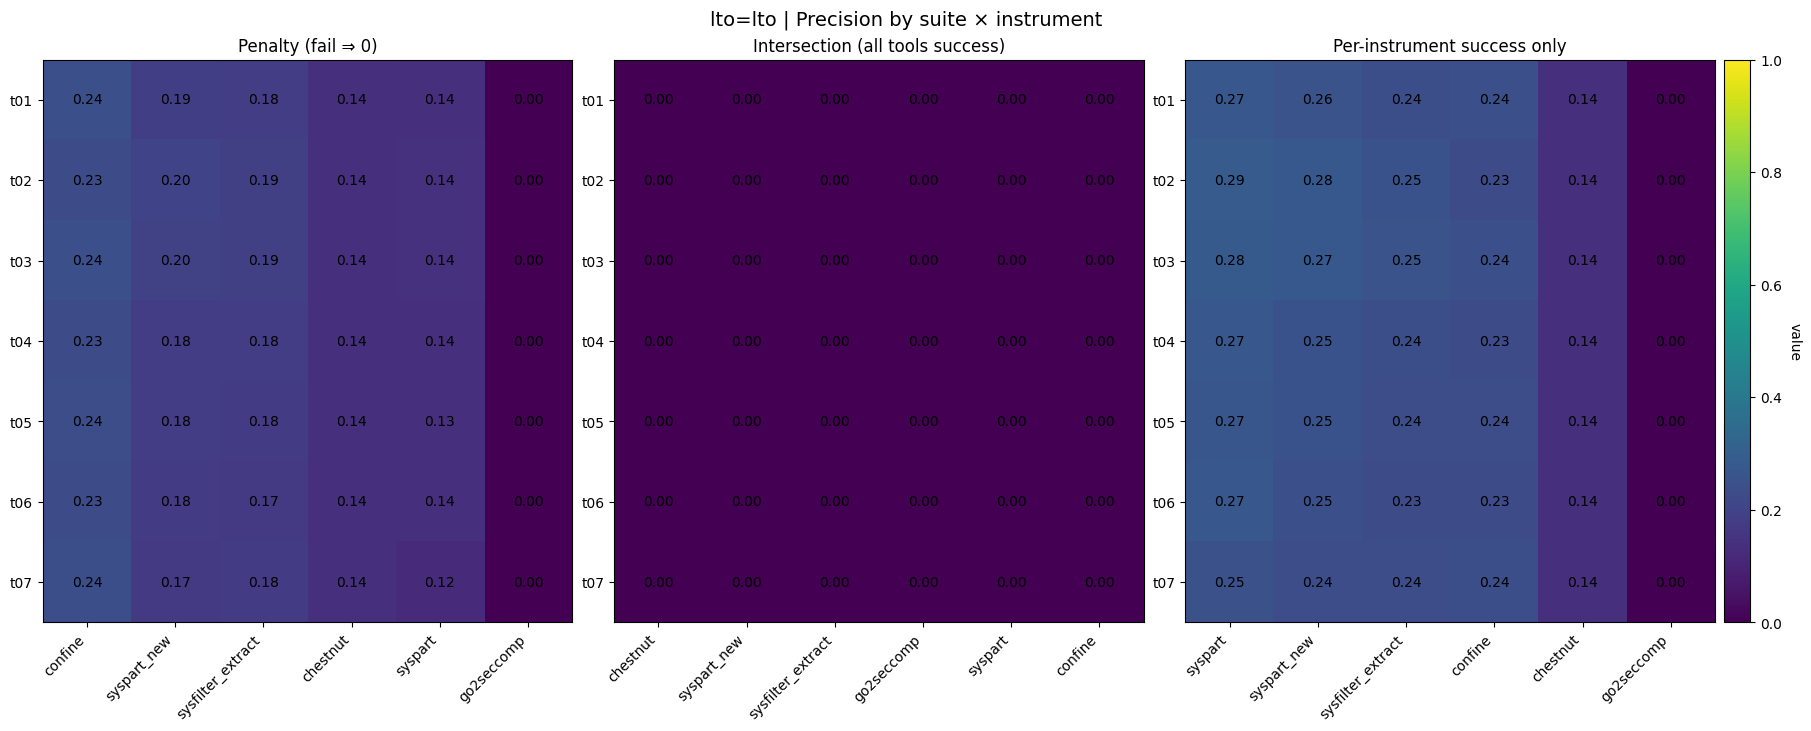

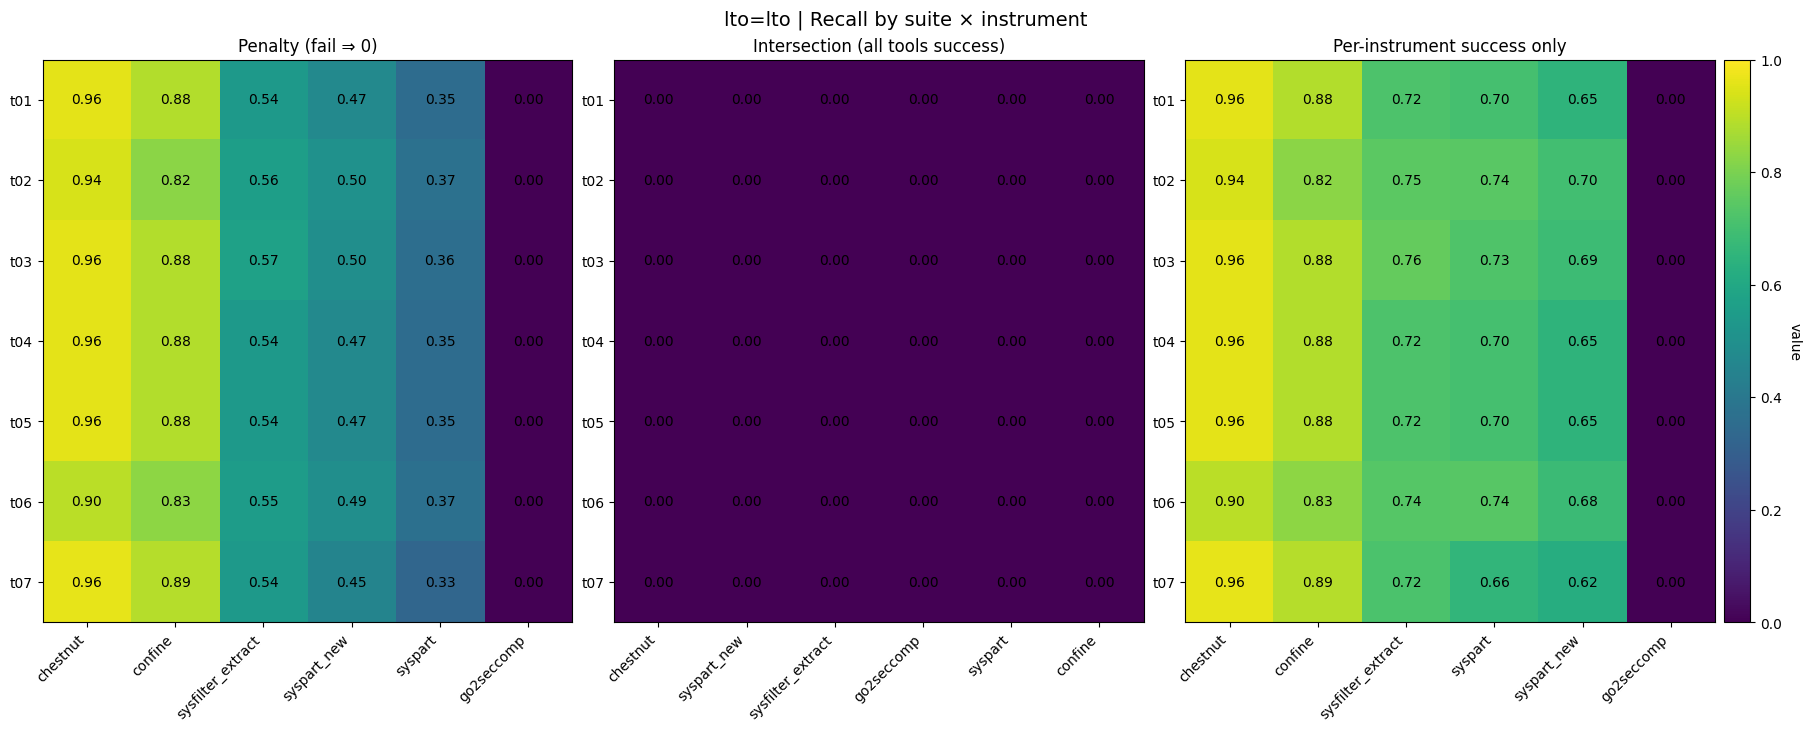

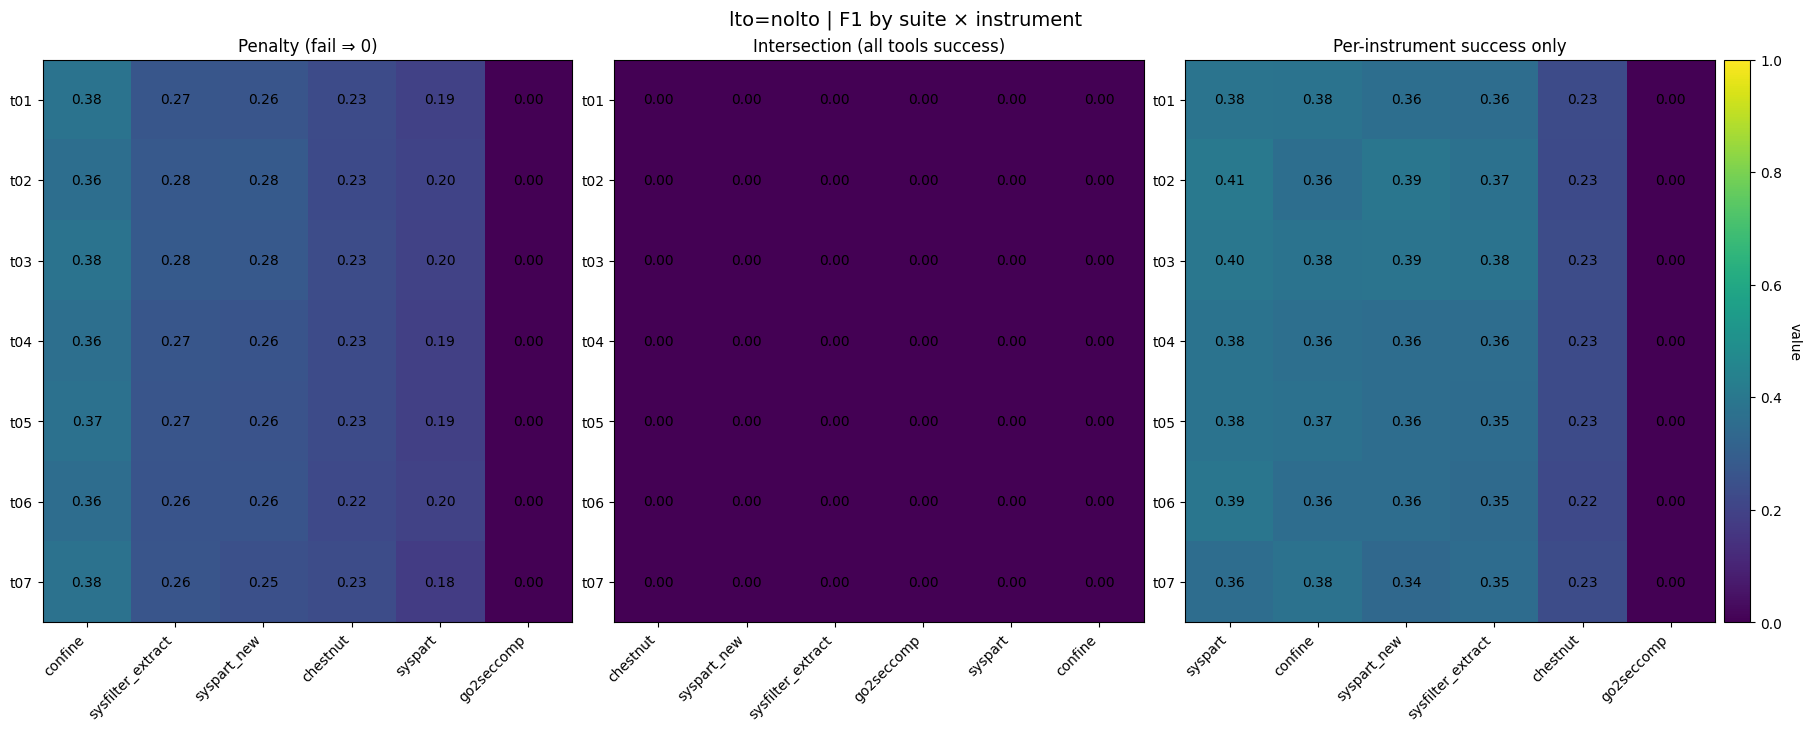

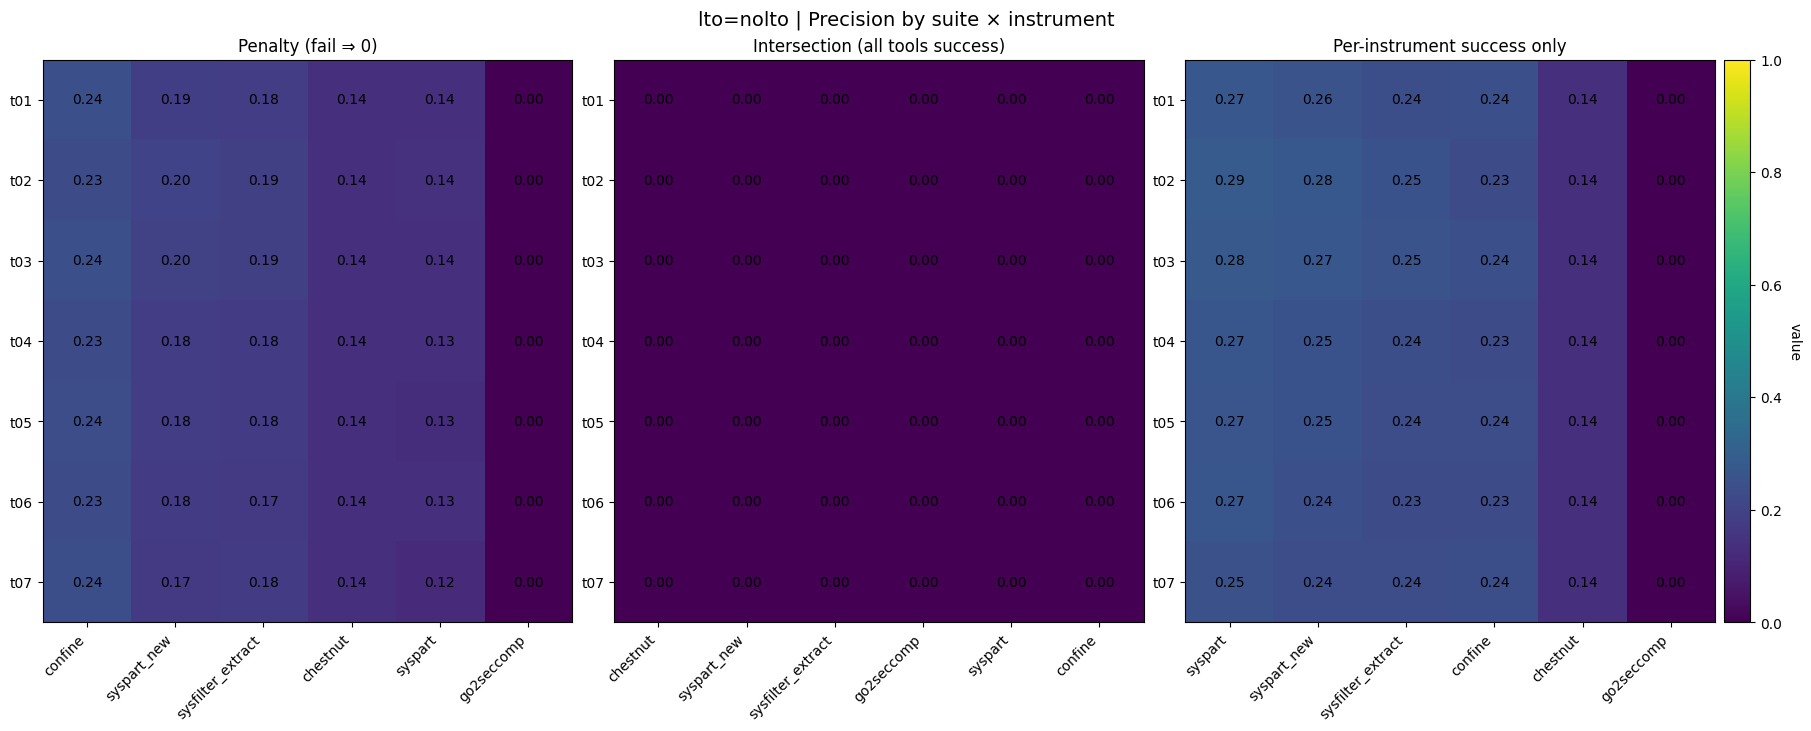

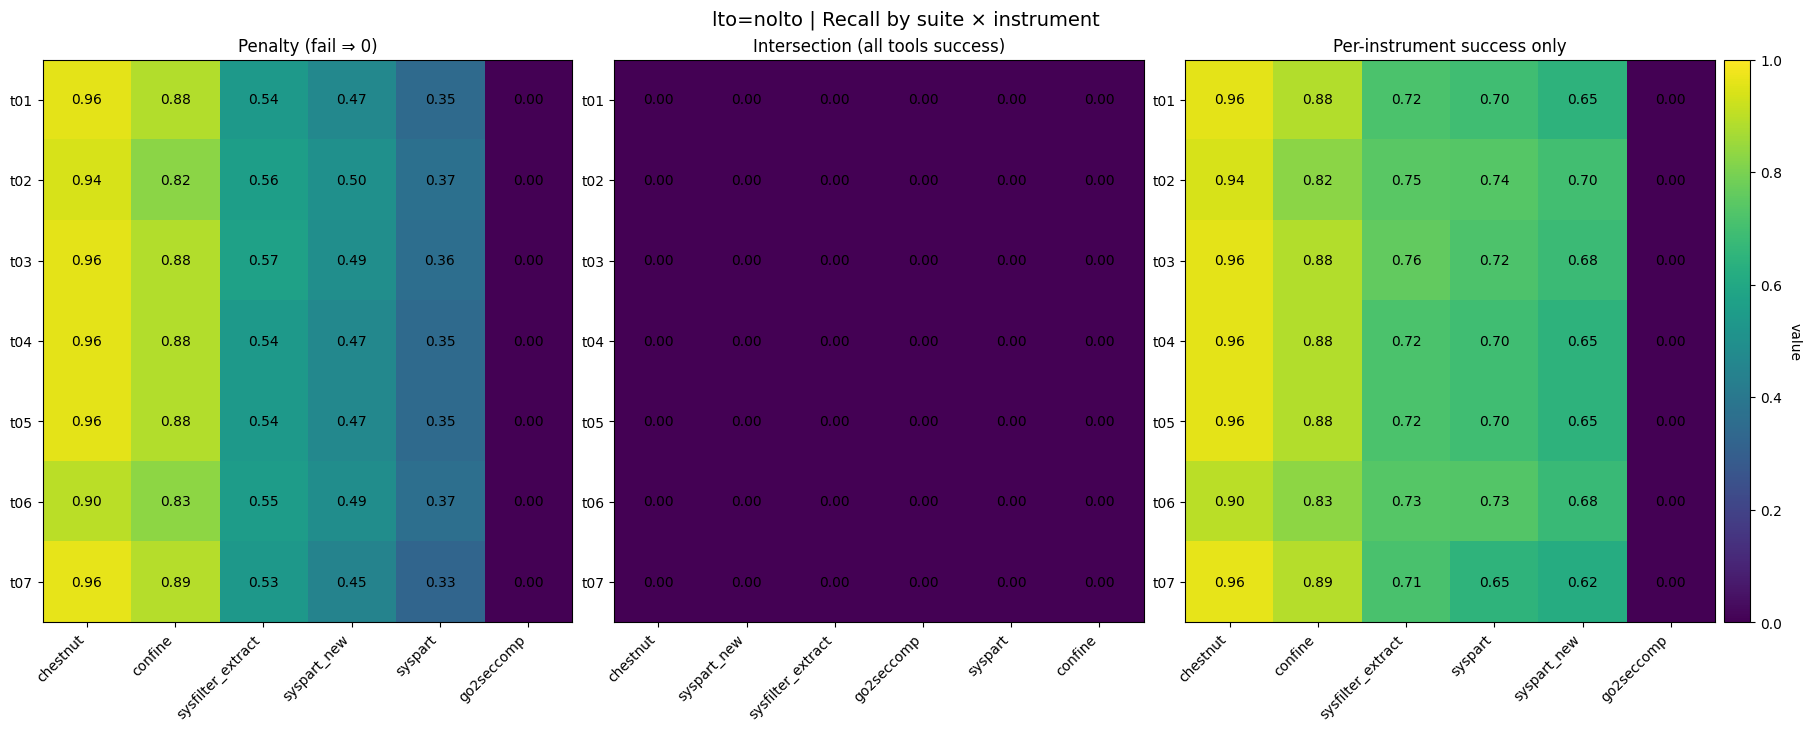

success_rate__penalty  avg_tp__penalty  avg_fp__penalty  \
instrument                                                                   
confine                           1.0000          13.9462          40.3807   
sysfilter_extract                 0.7353           9.3529          26.5496   
chestnut                          1.0000          15.2168         151.2387   
syspart_new                       0.6672           7.0908          19.2756   
syspart                           0.5000           5.9235          14.0462   
go2seccomp                        0.0471           0.8706           0.7294   

                   avg_fn__penalty  avg_tn__penalty  avg_precision__penalty  \
instrument                                                                    
confine                     2.0487         276.6244                  0.2586   
sysfilter_extract           3.0151         294.0824                  0.1900   
chestnut                    0.7782         165.7664                  0.1599   
syspart_new                 3.5361         303.0975                  0.1831   
syspart                     2.1697         310.8605                  0.1487   
go2seccomp                  0.1160         331.2840                  0.0258   

                   avg_recall__penalty  avg_f1__penalty  n__penalty  \
instrument                                                            
confine                         0.8629           0.3927        1190   
sysfilter_extract               0.5446           0.2794        1190   
chestnut                        0.9402           0.2531        1190   
syspart_new                     0.4441           0.2531        1190   
syspart                         0.3590           0.2069        1190   
go2seccomp                      0.0424           0.0317        1190   

                   micro_precision__penalty  ...  avg_fp__soft  avg_fn__soft  \
instrument                                   ...                               
confine                              0.2567  ...       40.3807        2.0487   
sysfilter_extract                    0.2605  ...       36.1074        4.1006   
chestnut                             0.0914  ...      151.2387        0.7782   
syspart_new                          0.2689  ...       28.8892        5.2997   
syspart                              0.2966  ...       28.0924        4.3395   
go2seccomp                           0.5441  ...       15.5000        2.4643   

                   avg_tn__soft  avg_precision__soft  avg_recall__soft  \
instrument                                                               
confine                276.6244               0.2586            0.8629   
sysfilter_extract      280.0720               0.2584            0.7407   
chestnut               165.7664               0.1599            0.9402   
syspart_new            288.1839               0.2744            0.6655   
syspart                288.7210               0.2974            0.7180   
go2seccomp             296.5357               0.5487            0.9008   

                   avg_f1__soft  n__soft  micro_precision__soft  \
instrument                                                        
confine                  0.3927     1190                 0.2567   
sysfilter_extract        0.3799      875                 0.2605   
chestnut                 0.2531     1190                 0.0914   
syspart_new              0.3793      794                 0.2689   
syspart                  0.4137      595                 0.2966   
go2seccomp               0.6738       56                 0.5441   

                   micro_recall__soft  micro_f1__soft  
instrument                                             
confine                        0.8719          0.3966  
sysfilter_extract              0.7562          0.3875  
chestnut                       0.9514          0.1668  
syspart_new                    0.6672          0.3834  
syspart                        0.7319          0.4222  
go2seccomp                   

runs  success  fail  success_rate
instrument                                          
confine            1190     1190     0        1.0000
sysfilter_extract  1190      875   315        0.7353
chestnut           1190     1190     0        1.0000
syspart_new        1190      794   396        0.6672
syspart            1190      595   595        0.5000
go2seccomp         1190       56  1134        0.0471

instrument  exit_code  count
0             confine          0   1190
1   sysfilter_extract          0    875
2   sysfilter_extract        139    287
3   sysfilter_extract        134     28
4            chestnut          0   1190
5         syspart_new          0    794
6         syspart_new        139    287
7         syspart_new        134     84
8         syspart_new        124     25
9             syspart          0    595
10            syspart        139    567
11            syspart        124     28
12         go2seccomp          1   1134
13         go2seccomp          0     56

[matrix] penalty:f1


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
penalty:f1                                                                     
suite=t01          0.3961             0.2766    0.2515       0.2506   0.2048   
suite=t02          0.3906             0.2905    0.2546       0.2715   0.2181   
suite=t03          0.4065             0.2932    0.2600       0.2667   0.2134   
suite=t04          0.3824             0.2754    0.2491       0.2482   0.2040   
suite=t05          0.3896             0.2733    0.2515       0.2468   0.2024   
suite=t06          0.3794             0.2692    0.2435       0.2488   0.2088   
suite=t07          0.4041             0.2772    0.2614       0.2391   0.1968   
lang=c             0.3548             0.2619    0.2362       0.2654   0.1848   
lang=cpp           0.3554             0.2619    0.2362       0.2635   0.1837   
lang=go            0.5199             0.3311    0.3790       0.1871   0.2810   
lang=rust          0.4901             0.3348    0.2051       0.2601   0.2692   
opt=O0             0.3562             0.2669    0.2319       0.2652   0.1892   
opt=O2             0.3631             0.2651    0.2378       0.2682   0.1862   
opt=O3             0.4950             0.3317    0.2405       0.2600   0.2722   
opt=cgo            0.4905             0.3091    0.3602       0.0976   0.2642   
opt=clang          0.3513             0.2568    0.2360       0.2604   0.1814   
opt=clang++        0.3513             0.2568    0.2360       0.2571   0.1794   
opt=enabled        0.5378             0.3256    0.3920       0.1040   0.2799   
opt=exe            0.6080             0.2092    0.6102       0.2092   0.2092   
opt=g++            0.3531             0.2568    0.2360       0.2584   0.1814   
opt=gcc            0.3531             0.2568    0.2360       0.2584   0.1814   
opt=lto            0.4876             0.3458    0.1660       0.2612   0.2733   
opt=musl           0.4972             0.2638    0.4987       0.2788   0.2788   
opt=nolto          0.4880             0.3363    0.1660       0.2541   0.2584   
opt=pie            0.4506             0.4845    0.1582       0.3449   0.3743   
opt=pure           0.4815             0.3272    0.3522       0.2597   0.2735   
compiler=O0        0.4881             0.3410    0.1660       0.2576   0.2658   
compiler=O3        0.4894             0.3256    0.2325       0.2619   0.2684   
compiler=c         0.3522             0.2568    0.2360       0.2594   0.1814   
compiler=cgo       0.5378             0.3256    0.3920       0.1040   0.2799   
compiler=clang     0.3565             0.2639    0.2363       0.2671   0.1861   
compiler=clang++   0.3580             0.2639    0.2363       0.2637   0.1841   
compiler=cpp       0.3522             0.2568    0.2360       0.2578   0.1804   
compiler=g++       0.3554             0.2639    0.2363       0.2679   0.1858   
compiler=gcc       0.3552             0.2639    0.2363       0.2685   0.1861   
compiler=go        0.4860             0.3182    0.3562       0.1786   0.2689   
compiler=pure      0.5293             0.3468    0.3842       0.2771   0.2917   
compiler=rust      0.4931             0.3408    0.2106       0.2603   0.2739   
link=dbg           0.4892             0.3579    0.3602       0.1463   0.2713   
link=dyn           0.3900             0.3710    0.1183       0.3680   0.2217   
link=nopie         0.3522             0.2405    0.2360       0.2496   0.1719   
link=pie           0.3522             0.2731    0.2360       0.2675   0.1899   
link=rel           0.4892             0.3579    0.3602       0.1463   0.2713   
link=static        0.3326             0.1549    0.3599       0.1549   0.1549   
link=strip         0.5052             0.2208    0.2883       0.0317   0.1421   
link=unknown       0.5134             0.3929    0.3356       0.3286   0.3563   
strip=nostrip      0.3927             0.2794    0.2531       0.2531   0.2069   
pie_mode=nopie     0.3698             0.2455    0.2287       0.2525   0.1858   


[matrix] nopen:f1


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
nopen:f1                                                                       
suite=t01          0.5361             0.5854    0.5417       0.5854   0.5854   
suite=t02          0.6293             0.6341    0.6364       0.6341   0.6341   
suite=t03          0.6293             0.6341    0.6364       0.6341   0.6341   
suite=t04          0.5306             0.5854    0.5417       0.5854   0.5854   
suite=t05          0.5306             0.5854    0.5417       0.5854   0.5854   
suite=t06          0.5762             0.6256    0.5827       0.6256   0.6256   
suite=t07          0.6438             0.6500    0.6512       0.6500   0.6500   
lang=go            0.5823             0.6143    0.5902       0.6143   0.6143   
opt=cgo            0.5306             0.5854    0.5417       0.5854   0.5854   
opt=enabled        0.6013             0.6241    0.6080       0.6241   0.6241   
opt=exe            0.6046             0.6276    0.6113       0.6276   0.6276   
opt=pure           0.5306             0.5854    0.5417       0.5854   0.5854   
compiler=cgo       0.6013             0.6241    0.6080       0.6241   0.6241   
compiler=go        0.5306             0.5854    0.5417       0.5854   0.5854   
compiler=pure      0.6046             0.6276    0.6113       0.6276   0.6276   
link=dbg           0.5306             0.5854    0.5417       0.5854   0.5854   
link=rel           0.5306             0.5854    0.5417       0.5854   0.5854   
link=unknown       0.5909             0.6191    0.5983       0.6191   0.6191   
strip=nostrip      0.5823             0.6143    0.5902       0.6143   0.6143   
pie_mode=unknown   0.5823             0.6143    0.5902       0.6143   0.6143   
lto_mode=unknown   0.5823             0.6143    0.5902       0.6143   0.6143   

instrument        go2seccomp  
nopen:f1                      
suite=t01             0.6415  
suite=t02             0.6522  
suite=t03             0.7083  
suite=t04             0.5862  
suite=t05             0.6415  
suite=t06             0.6871  
suite=t07             0.6531  
lang=go               0.6528  
opt=cgo               0.6139  
opt=enabled           0.6671  
opt=exe               0.6698  
opt=pure              0.6139  
compiler=cgo          0.6671  
compiler=go           0.6139  
compiler=pure         0.6698  
link=dbg              0.6139  
link=rel              0.6139  
link=unknown          0.6593  
strip=nostrip         0.6528  
pie_mode=unknown      0.6528  
lto_mode=unknown      0.6528

[matrix] soft:f1


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
soft:f1                                                                        
suite=t01          0.3961             0.3761    0.2515       0.3770   0.4096   
suite=t02          0.3906             0.3950    0.2546       0.4084   0.4362   
suite=t03          0.4065             0.3988    0.2600       0.3977   0.4267   
suite=t04          0.3824             0.3746    0.2491       0.3734   0.4079   
suite=t05          0.3896             0.3717    0.2515       0.3713   0.4048   
suite=t06          0.3794             0.3662    0.2435       0.3710   0.4175   
suite=t07          0.4041             0.3770    0.2614       0.3566   0.3935   
lang=c             0.3548             0.3491    0.2362       0.3539   0.3696   
lang=cpp           0.3554             0.3491    0.2362       0.3514   0.3673   
lang=go            0.5199             0.4966    0.3790       0.5329   0.5619   
lang=rust          0.4901             0.4636    0.2051       0.5201   0.5384   
opt=O0             0.3562             0.3559    0.2319       0.3593   0.3784   
opt=O2             0.3631             0.3535    0.2378       0.3576   0.3725   
opt=O3             0.4950             0.4739    0.2405       0.5200   0.5445   
opt=cgo            0.4905             0.4636    0.3602       0.5854   0.5285   
opt=clang          0.3513             0.3424    0.2360       0.3473   0.3629   
opt=clang++        0.3513             0.3424    0.2360       0.3429   0.3588   
opt=enabled        0.5378             0.4884    0.3920       0.4801   0.5598   
opt=exe            0.6080             0.6276    0.6102       0.6276   0.6276   
opt=g++            0.3531             0.3424    0.2360       0.3445   0.3629   
opt=gcc            0.3531             0.3424    0.2360       0.3445   0.3629   
opt=lto            0.4876             0.4610    0.1660       0.5224   0.5465   
opt=musl           0.4972             0.5275    0.4987       0.5577   0.5577   
opt=nolto          0.4880             0.4484    0.1660       0.5082   0.5169   
opt=pie            0.4506             0.4845    0.1582       0.5174   0.5614   
opt=pure           0.4815             0.4909    0.3522       0.5194   0.5470   
compiler=O0        0.4881             0.4547    0.1660       0.5153   0.5317   
compiler=O3        0.4894             0.4651    0.2325       0.5237   0.5369   
compiler=c         0.3522             0.3424    0.2360       0.3459   0.3629   
compiler=cgo       0.5378             0.4884    0.3920       0.4801   0.5598   
compiler=clang     0.3565             0.3518    0.2363       0.3561   0.3723   
compiler=clang++   0.3580             0.3518    0.2363       0.3517   0.3683   
compiler=cpp       0.3522             0.3424    0.2360       0.3437   0.3608   
compiler=g++       0.3554             0.3518    0.2363       0.3572   0.3715   
compiler=gcc       0.3552             0.3518    0.2363       0.3580   0.3723   
compiler=go        0.4860             0.4773    0.3562       0.5359   0.5377   
compiler=pure      0.5293             0.5202    0.3842       0.5541   0.5835   
compiler=rust      0.4931             0.4719    0.2106       0.5206   0.5478   
link=dbg           0.4892             0.4772    0.3602       0.5854   0.5427   
link=dyn           0.3900             0.3796    0.1183       0.3856   0.4433   
link=nopie         0.3522             0.3207    0.2360       0.3328   0.3438   
link=pie           0.3522             0.3641    0.2360       0.3567   0.3799   
link=rel           0.4892             0.4772    0.3602       0.5854   0.5427   
link=static        0.3326             0.3097    0.3599       0.3097   0.3097   
link=strip         0.5052             0.4513    0.2883       0.4865   0.5230   
link=unknown       0.5134             0.4959    0.3356       0.5272   0.5599   
strip=nostrip      0.3927             0.3799    0.2531       0.3793   0.4137   
pie_mode=nopie     0.3698             0.3399    0.2287       0.3497   0.3716   


[matrix] penalty:precision


instrument         confine  sysfilter_extract  chestnut  syspart_new  syspart  \
penalty:precision                                                               
suite=t01           0.2598             0.1887    0.1566       0.1798   0.1478   
suite=t02           0.2604             0.1987    0.1620       0.1952   0.1577   
suite=t03           0.2696             0.2004    0.1652       0.1981   0.1548   
suite=t04           0.2486             0.1876    0.1548       0.1774   0.1469   
suite=t05           0.2545             0.1858    0.1566       0.1761   0.1455   
suite=t06           0.2509             0.1805    0.1580       0.1794   0.1473   
suite=t07           0.2662             0.1885    0.1660       0.1755   0.1410   
lang=c              0.2236             0.1735    0.1427       0.1832   0.1274   
lang=cpp            0.2239             0.1735    0.1427       0.1814   0.1262   
lang=go             0.3869             0.2453    0.2805       0.1680   0.2206   
lang=rust           0.3353             0.2338    0.1209       0.2086   0.2086   
opt=O0              0.2264             0.1773    0.1402       0.1841   0.1311   
opt=O2              0.2293             0.1756    0.1442       0.1848   0.1281   
opt=O3              0.3389             0.2351    0.1477       0.2123   0.2154   
opt=cgo             0.3596             0.2262    0.2588       0.0833   0.2061   
opt=clang           0.2195             0.1703    0.1413       0.1802   0.1252   
opt=clang++         0.2195             0.1703    0.1413       0.1769   0.1231   
opt=enabled         0.4043             0.2382    0.2923       0.1382   0.2186   
opt=exe             0.4872             0.1778    0.4900       0.1778   0.1778   
opt=g++             0.2209             0.1703    0.1413       0.1782   0.1252   
opt=gcc             0.2209             0.1703    0.1413       0.1782   0.1252   
opt=lto             0.3329             0.2366    0.0905       0.2043   0.2058   
opt=musl            0.3476             0.2188    0.3517       0.2478   0.2478   
opt=nolto           0.3332             0.2308    0.0905       0.2024   0.1976   
opt=pie             0.3028             0.3424    0.0859       0.2572   0.2831   
opt=pure            0.3501             0.2451    0.2539       0.2033   0.2153   
compiler=O0         0.3333             0.2337    0.0905       0.2033   0.2017   
compiler=O3         0.3358             0.2307    0.1428       0.2122   0.2109   
compiler=c          0.2202             0.1703    0.1413       0.1792   0.1252   
compiler=cgo        0.4043             0.2382    0.2923       0.1382   0.2186   
compiler=clang      0.2254             0.1748    0.1433       0.1844   0.1282   
compiler=clang++    0.2262             0.1748    0.1433       0.1811   0.1262   
compiler=cpp        0.2202             0.1703    0.1413       0.1776   0.1242   
compiler=g++        0.2246             0.1748    0.1433       0.1847   0.1279   
compiler=gcc        0.2245             0.1748    0.1433       0.1853   0.1282   
compiler=go         0.3548             0.2356    0.2564       0.1433   0.2107   
compiler=pure       0.3950             0.2601    0.2880       0.2175   0.2305   
compiler=rust       0.3369             0.2381    0.1242       0.2096   0.2130   
link=dbg            0.3581             0.2679    0.2588       0.1250   0.2171   
link=dyn            0.2486             0.2489    0.0630       0.2621   0.1603   
link=nopie          0.2202             0.1608    0.1413       0.1745   0.1196   
link=pie            0.2202             0.1798    0.1413       0.1823   0.1298   
link=rel            0.3581             0.2679    0.2588       0.1250   0.2171   
link=static         0.2104             0.1000    0.2269       0.1000   0.1000   
link=strip          0.3628             0.1508    0.1981       0.0235   0.1056   
link=unknown        0.3728             0.2907    0.2400       0.2841   0.2820   
strip=nostrip       0.2586             0.1900    0.1599       0.1831   0.1487   
pie_mode=nopie      0.2358     

[matrix] nopen:precision


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
nopen:precision                                                                
suite=t01          0.4128             0.5000    0.4194       0.5000   0.5000   
suite=t02          0.5093             0.5417    0.5185       0.5417   0.5417   
suite=t03          0.5093             0.5417    0.5185       0.5417   0.5417   
suite=t04          0.4062             0.5000    0.4194       0.5000   0.5000   
suite=t05          0.4062             0.5000    0.4194       0.5000   0.5000   
suite=t06          0.4636             0.5312    0.4722       0.5312   0.5312   
suite=t07          0.5093             0.5417    0.5185       0.5417   0.5417   
lang=go            0.4595             0.5223    0.4694       0.5223   0.5223   
opt=cgo            0.4062             0.5000    0.4194       0.5000   0.5000   
opt=enabled        0.4790             0.5292    0.4876       0.5292   0.5292   
opt=exe            0.4827             0.5333    0.4913       0.5333   0.5333   
opt=pure           0.4062             0.5000    0.4194       0.5000   0.5000   
compiler=cgo       0.4790             0.5292    0.4876       0.5292   0.5292   
compiler=go        0.4062             0.5000    0.4194       0.5000   0.5000   
compiler=pure      0.4827             0.5333    0.4913       0.5333   0.5333   
link=dbg           0.4062             0.5000    0.4194       0.5000   0.5000   
link=rel           0.4062             0.5000    0.4194       0.5000   0.5000   
link=unknown       0.4684             0.5260    0.4777       0.5260   0.5260   
strip=nostrip      0.4595             0.5223    0.4694       0.5223   0.5223   
pie_mode=unknown   0.4595             0.5223    0.4694       0.5223   0.5223   
lto_mode=unknown   0.4595             0.5223    0.4694       0.5223   0.5223   

instrument        go2seccomp  
nopen:precision               
suite=t01             0.4722  
suite=t02             0.5172  
suite=t03             0.5484  
suite=t04             0.4146  
suite=t05             0.4722  
suite=t06             0.5234  
suite=t07             0.4848  
lang=go               0.4904  
opt=cgo               0.4434  
opt=enabled           0.5077  
opt=exe               0.5108  
opt=pure              0.4434  
compiler=cgo          0.5077  
compiler=go           0.4434  
compiler=pure         0.5108  
link=dbg              0.4434  
link=rel              0.4434  
link=unknown          0.4983  
strip=nostrip         0.4904  
pie_mode=unknown      0.4904  
lto_mode=unknown      0.4904

[matrix] soft:precision


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
soft:precision                                                                 
suite=t01          0.2598             0.2566    0.1566       0.2706   0.2957   
suite=t02          0.2604             0.2702    0.1620       0.2936   0.3153   
suite=t03          0.2696             0.2726    0.1652       0.2954   0.3095   
suite=t04          0.2486             0.2551    0.1548       0.2668   0.2938   
suite=t05          0.2545             0.2526    0.1566       0.2650   0.2909   
suite=t06          0.2509             0.2455    0.1580       0.2675   0.2945   
suite=t07          0.2662             0.2564    0.1660       0.2617   0.2820   
lang=c             0.2236             0.2314    0.1427       0.2443   0.2548   
lang=cpp           0.2239             0.2314    0.1427       0.2418   0.2524   
lang=go            0.3869             0.3679    0.2805       0.4783   0.4412   
lang=rust          0.3353             0.3237    0.1209       0.4173   0.4172   
opt=O0             0.2264             0.2364    0.1402       0.2494   0.2623   
opt=O2             0.2293             0.2341    0.1442       0.2463   0.2562   
opt=O3             0.3389             0.3358    0.1477       0.4246   0.4307   
opt=cgo            0.3596             0.3393    0.2588       0.5000   0.4123   
opt=clang          0.2195             0.2270    0.1413       0.2403   0.2504   
opt=clang++        0.2195             0.2270    0.1413       0.2359   0.2463   
opt=enabled        0.4043             0.3572    0.2923       0.6378   0.4372   
opt=exe            0.4872             0.5333    0.4900       0.5333   0.5333   
opt=g++            0.2209             0.2270    0.1413       0.2376   0.2504   
opt=gcc            0.2209             0.2270    0.1413       0.2376   0.2504   
opt=lto            0.3329             0.3155    0.0905       0.4085   0.4117   
opt=musl           0.3476             0.4376    0.3517       0.4956   0.4956   
opt=nolto          0.3332             0.3077    0.0905       0.4048   0.3951   
opt=pie            0.3028             0.3424    0.0859       0.3858   0.4247   
opt=pure           0.3501             0.3676    0.2539       0.4067   0.4306   
compiler=O0        0.3333             0.3116    0.0905       0.4066   0.4034   
compiler=O3        0.3358             0.3296    0.1428       0.4244   0.4218   
compiler=c         0.2202             0.2270    0.1413       0.2390   0.2504   
compiler=cgo       0.4043             0.3572    0.2923       0.6378   0.4372   
compiler=clang     0.2254             0.2331    0.1433       0.2459   0.2565   
compiler=clang++   0.2262             0.2331    0.1433       0.2414   0.2524   
compiler=cpp       0.2202             0.2270    0.1413       0.2368   0.2483   
compiler=g++       0.2246             0.2331    0.1433       0.2463   0.2558   
compiler=gcc       0.2245             0.2331    0.1433       0.2471   0.2565   
compiler=go        0.3548             0.3534    0.2564       0.4300   0.4214   
compiler=pure      0.3950             0.3901    0.2880       0.4350   0.4609   
compiler=rust      0.3369             0.3296    0.1242       0.4192   0.4260   
link=dbg           0.3581             0.3571    0.2588       0.5000   0.4342   
link=dyn           0.2486             0.2547    0.0630       0.2746   0.3205   
link=nopie         0.2202             0.2144    0.1413       0.2326   0.2392   
link=pie           0.2202             0.2397    0.1413       0.2431   0.2595   
link=rel           0.3581             0.3571    0.2588       0.5000   0.4342   
link=static        0.2104             0.2000    0.2269       0.2000   0.2000   
link=strip         0.3628             0.3083    0.1981       0.3600   0.3885   
link=unknown       0.3728             0.3669    0.2400       0.4558   0.4432   
strip=nostrip      0.2586             0.2584    0.1599       0.2744   0.2974   
pie_mode=nopie     0.2358             0.2272    0.1371       0.2469   0.2615   


[matrix] penalty:recall


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
penalty:recall                                                                 
suite=t01          0.8720             0.5347    0.9477       0.4344   0.3530   
suite=t02          0.8287             0.5575    0.9355       0.4682   0.3753   
suite=t03          0.8783             0.5649    0.9518       0.4589   0.3661   
suite=t04          0.8720             0.5347    0.9477       0.4344   0.3530   
suite=t05          0.8721             0.5347    0.9477       0.4344   0.3530   
suite=t06          0.8282             0.5480    0.8937       0.4563   0.3722   
suite=t07          0.8888             0.5380    0.9576       0.4218   0.3401   
lang=c             0.8619             0.5377    0.9418       0.4932   0.3488   
lang=cpp           0.8639             0.5377    0.9418       0.4932   0.3488   
lang=go            0.8264             0.5386    0.8984       0.2536   0.3942   
lang=rust          0.9112             0.6018    0.9847       0.3483   0.3848   
opt=O0             0.8418             0.5444    0.9355       0.4879   0.3522   
opt=O2             0.8747             0.5451    0.9413       0.5004   0.3526   
opt=O3             0.9197             0.5817    0.9750       0.3409   0.3793   
opt=cgo            0.7898             0.5251    0.8824       0.1176   0.3769   
opt=clang          0.8797             0.5267    0.9545       0.4826   0.3429   
opt=clang++        0.8797             0.5267    0.9545       0.4826   0.3429   
opt=enabled        0.8329             0.5510    0.9047       0.1268   0.3969   
opt=exe            0.8098             0.2542    0.8098       0.2542   0.2542   
opt=g++            0.8797             0.5267    0.9545       0.4826   0.3429   
opt=gcc            0.8797             0.5267    0.9545       0.4826   0.3429   
opt=lto            0.9105             0.6421    1.0000       0.3623   0.4065   
opt=musl           0.8759             0.3330    0.8571       0.3205   0.3205   
opt=nolto          0.9116             0.6200    1.0000       0.3421   0.3743   
opt=pie            0.8809             0.8289    1.0000       0.5239   0.5525   
opt=pure           0.7993             0.5138    0.8824       0.3676   0.3815   
compiler=O0        0.9116             0.6310    1.0000       0.3522   0.3904   
compiler=O3        0.9036             0.5714    0.9714       0.3459   0.3764   
compiler=c         0.8797             0.5267    0.9545       0.4826   0.3429   
compiler=cgo       0.8329             0.5510    0.9047       0.1268   0.3969   
compiler=clang     0.8558             0.5421    0.9368       0.4960   0.3511   
compiler=clang++   0.8613             0.5421    0.9368       0.4960   0.3511   
compiler=cpp       0.8797             0.5267    0.9545       0.4826   0.3429   
compiler=g++       0.8539             0.5421    0.9368       0.4990   0.3511   
compiler=gcc       0.8539             0.5421    0.9368       0.4990   0.3511   
compiler=go        0.7945             0.5194    0.8824       0.2426   0.3792   
compiler=pure      0.8454             0.5415    0.9049       0.3890   0.4033   
compiler=rust      0.9212             0.6116    0.9861       0.3475   0.3902   
link=dbg           0.7898             0.5839    0.8824       0.1765   0.3709   
link=dyn           0.9157             0.7317    1.0000       0.6238   0.3620   
link=nopie         0.8797             0.4826    0.9545       0.4532   0.3209   
link=pie           0.8797             0.5709    0.9545       0.5120   0.3650   
link=rel           0.7898             0.5839    0.8824       0.1765   0.3709   
link=static        0.7975             0.3443    0.8735       0.3443   0.3443   
link=strip         0.8594             0.4126    0.9406       0.0489   0.2175   
link=unknown       0.8598             0.6380    0.9243       0.4401   0.4924   
strip=nostrip      0.8629             0.5446    0.9402       0.4441   0.3590   
pie_mode=nopie     0.8686             0.4920    0.9483       0.4498   0.3360   


[matrix] nopen:recall


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
nopen:recall                                                                   
suite=t01          0.7647             0.7059    0.7647       0.7059   0.7059   
suite=t02          0.8235             0.7647    0.8235       0.7647   0.7647   
suite=t03          0.8235             0.7647    0.8235       0.7647   0.7647   
suite=t04          0.7647             0.7059    0.7647       0.7059   0.7059   
suite=t05          0.7647             0.7059    0.7647       0.7059   0.7059   
suite=t06          0.7610             0.7610    0.7610       0.7610   0.7610   
suite=t07          0.8750             0.8125    0.8750       0.8125   0.8125   
lang=go            0.7967             0.7458    0.7967       0.7458   0.7458   
opt=cgo            0.7647             0.7059    0.7647       0.7059   0.7059   
opt=enabled        0.8088             0.7610    0.8088       0.7610   0.7610   
opt=exe            0.8103             0.7625    0.8103       0.7625   0.7625   
opt=pure           0.7647             0.7059    0.7647       0.7059   0.7059   
compiler=cgo       0.8088             0.7610    0.8088       0.7610   0.7610   
compiler=go        0.7647             0.7059    0.7647       0.7059   0.7059   
compiler=pure      0.8103             0.7625    0.8103       0.7625   0.7625   
link=dbg           0.7647             0.7059    0.7647       0.7059   0.7059   
link=rel           0.7647             0.7059    0.7647       0.7059   0.7059   
link=unknown       0.8021             0.7525    0.8021       0.7525   0.7525   
strip=nostrip      0.7967             0.7458    0.7967       0.7458   0.7458   
pie_mode=unknown   0.7967             0.7458    0.7967       0.7458   0.7458   
lto_mode=unknown   0.7967             0.7458    0.7967       0.7458   0.7458   

instrument        go2seccomp  
nopen:recall                  
suite=t01             1.0000  
suite=t02             0.8824  
suite=t03             1.0000  
suite=t04             1.0000  
suite=t05             1.0000  
suite=t06             1.0000  
suite=t07             1.0000  
lang=go               0.9832  
opt=cgo               1.0000  
opt=enabled           0.9765  
opt=exe               0.9765  
opt=pure              1.0000  
compiler=cgo          0.9765  
compiler=go           1.0000  
compiler=pure         0.9765  
link=dbg              1.0000  
link=rel              1.0000  
link=unknown          0.9804  
strip=nostrip         0.9832  
pie_mode=unknown      0.9832  
lto_mode=unknown      0.9832

[matrix] soft:recall


instrument        confine  sysfilter_extract  chestnut  syspart_new  syspart  \
soft:recall                                                                    
suite=t01          0.8720             0.7272    0.9477       0.6536   0.7061   
suite=t02          0.8287             0.7582    0.9355       0.7043   0.7507   
suite=t03          0.8783             0.7682    0.9518       0.6843   0.7322   
suite=t04          0.8720             0.7272    0.9477       0.6536   0.7061   
suite=t05          0.8721             0.7272    0.9477       0.6536   0.7061   
suite=t06          0.8282             0.7453    0.8937       0.6804   0.7443   
suite=t07          0.8888             0.7317    0.9576       0.6290   0.6803   
lang=c             0.8619             0.7170    0.9418       0.6577   0.6975   
lang=cpp           0.8639             0.7170    0.9418       0.6577   0.6975   
lang=go            0.8264             0.8079    0.8984       0.7220   0.7883   
lang=rust          0.9112             0.8333    0.9847       0.6967   0.7696   
opt=O0             0.8418             0.7259    0.9355       0.6611   0.7044   
opt=O2             0.8747             0.7268    0.9413       0.6672   0.7051   
opt=O3             0.9197             0.8310    0.9750       0.6817   0.7587   
opt=cgo            0.7898             0.7876    0.8824       0.7059   0.7538   
opt=clang          0.8797             0.7023    0.9545       0.6435   0.6858   
opt=clang++        0.8797             0.7023    0.9545       0.6435   0.6858   
opt=enabled        0.8329             0.8266    0.9047       0.5854   0.7939   
opt=exe            0.8098             0.7625    0.8098       0.7625   0.7625   
opt=g++            0.8797             0.7023    0.9545       0.6435   0.6858   
opt=gcc            0.8797             0.7023    0.9545       0.6435   0.6858   
opt=lto            0.9105             0.8561    1.0000       0.7246   0.8131   
opt=musl           0.8759             0.6661    0.8571       0.6411   0.6411   
opt=nolto          0.9116             0.8266    1.0000       0.6842   0.7486   
opt=pie            0.8809             0.8289    1.0000       0.7859   0.8288   
opt=pure           0.7993             0.7707    0.8824       0.7353   0.7631   
compiler=O0        0.9116             0.8414    1.0000       0.7044   0.7808   
compiler=O3        0.9036             0.8163    0.9714       0.6917   0.7529   
compiler=c         0.8797             0.7023    0.9545       0.6435   0.6858   
compiler=cgo       0.8329             0.8266    0.9047       0.5854   0.7939   
compiler=clang     0.8558             0.7228    0.9368       0.6614   0.7022   
compiler=clang++   0.8613             0.7228    0.9368       0.6614   0.7022   
compiler=cpp       0.8797             0.7023    0.9545       0.6435   0.6858   
compiler=g++       0.8539             0.7228    0.9368       0.6653   0.7022   
compiler=gcc       0.8539             0.7228    0.9368       0.6653   0.7022   
compiler=go        0.7945             0.7792    0.8824       0.7279   0.7584   
compiler=pure      0.8454             0.8123    0.9049       0.7781   0.8067   
compiler=rust      0.9212             0.8469    0.9861       0.6950   0.7804   
link=dbg           0.7898             0.7785    0.8824       0.7059   0.7418   
link=dyn           0.9157             0.7487    1.0000       0.6535   0.7240   
link=nopie         0.8797             0.6435    0.9545       0.6043   0.6417   
link=pie           0.8797             0.7611    0.9545       0.6827   0.7299   
link=rel           0.7898             0.7785    0.8824       0.7059   0.7418   
link=static        0.7975             0.6887    0.8735       0.6887   0.6887   
link=strip         0.8594             0.8436    0.9406       0.7500   0.8005   
link=unknown       0.8598             0.8053    0.9243       0.7061   0.7738   
strip=nostrip      0.8629             0.7407    0.9402       0.6655   0.7180   
pie_mode=nopie     0.8686             0.6812    0.9483       0.6228   0.6721   


instrument                     confine  sysfilter_extract  chestnut  \
penalty__f1  suite=t01          0.3961             0.2766    0.2515   
             suite=t02          0.3906             0.2905    0.2546   
             suite=t03          0.4065             0.2932    0.2600   
             suite=t04          0.3824             0.2754    0.2491   
             suite=t05          0.3896             0.2733    0.2515   
...                                ...                ...       ...   
soft__recall pie_mode=pie       0.8669             0.7872    0.9557   
             pie_mode=unknown   0.8093             0.7275    0.8061   
             lto_mode=lto       0.8686             0.7333    0.9483   
             lto_mode=nolto     0.8687             0.7298    0.9483   
             lto_mode=unknown   0.8309             0.7989    0.8956   

instrument                     syspart_new  syspart  go2seccomp  
penalty__f1  suite=t01              0.2506   0.2048      0.0312  
             suite=t02              0.2715   0.2181      0.0318  
             suite=t03              0.2667   0.2134      0.0342  
             suite=t04              0.2482   0.2040      0.0287  
             suite=t05              0.2468   0.2024      0.0313  
...                                    ...      ...         ...  
soft__recall pie_mode=pie           0.7001   0.7552      0.8183  
             pie_mode=unknown       0.7204   0.7204      0.9832  
             lto_mode=lto           0.6629   0.7114         NaN  
             lto_mode=nolto         0.6599   0.7038         NaN  
             lto_mode=unknown       0.7111   0.7753      0.9008  

[381 rows x 6 columns]

In [4]:
WORKSPACE_PATH = "build/workspace"
INSTRUMENTS = list(INSTRUMENT_PREFIXES)

def normalize_instrument(name: str) -> str:
    return "sysfilter_extract" if name == "sysfilter" else name

ALL_SYSCALLS = set(SYSCALL_MAP.values())
UNIVERSE_N = len(ALL_SYSCALLS)

def load_workspace_all(workspace_path: str, syscall_map: dict):
    base_dir = os.path.join(workspace_path, "syscall_results")
    files = glob.glob(os.path.join(base_dir, "**", "*"), recursive=True)
    files = [p for p in files if os.path.isfile(p)]
    files = [p for p in files if "opt__test__build__" in p]

    pred_sets = {}
    exit_codes = {}

    for p in files:
        tail = p.split("__")[-1]
        if "/" not in tail:
            continue
        test_name, fname = tail.split("/", 1)

        if fname.endswith(".exitcode"):
            inst = normalize_instrument(fname.removesuffix(".exitcode"))
            try:
                with open(p, "r") as f:
                    line = next((x for x in f.read().splitlines() if x.strip()), None)
                if line is not None:
                    exit_codes[(test_name, inst)] = int(line.strip())
            except Exception:
                exit_codes[(test_name, inst)] = 999
            continue

        if fname.endswith(".syscalls.json"):
            inst = normalize_instrument(fname.split(".", 1)[0])
            try:
                with open(p, "r") as f:
                    nums = json.load(f)
                nums = [int(x) for x in nums]
                pred_sets[(test_name, inst)] = set(syscall_map.get(n, "unknown") for n in nums)
            except Exception:
                pred_sets[(test_name, inst)] = set()
            continue

        if fname.endswith(".syscalls.txt"):
            inst = normalize_instrument(fname.split(".", 1)[0])
            try:
                with open(p, "r") as f:
                    pred_sets[(test_name, inst)] = set(x for x in f.read().splitlines() if x.strip())
            except Exception:
                pred_sets[(test_name, inst)] = set()
            continue

    return pred_sets, exit_codes, len(files)

pred_sets, exit_codes, scanned_n = load_workspace_all(WORKSPACE_PATH, SYSCALL_MAP)
print(f"[scan] files scanned: {scanned_n}")
print(f"[scan] pred_sets pairs: {len(pred_sets)} | exit_codes pairs: {len(exit_codes)}")

def counts(valid_set, pred_set):
    valid_set = set(valid_set or [])
    pred_set = set(pred_set or [])
    tp = len(valid_set & pred_set)
    fp = len(pred_set - valid_set)
    fn = len(valid_set - pred_set)
    return tp, fp, fn

def prf(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) else 1.0
    recall = tp / (tp + fn) if (tp + fn) else 1.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 1.0
    return precision, recall, f1

def extract_option(test_name: str, idx: int) -> str:
    parts = test_name.split("_")
    return parts[idx] if len(parts) > idx else "unknown"

KNOWN_LANGS = {"c", "cpp", "go", "rust"}

def extract_lang(test_name: str) -> str:
    parts = test_name.split("_")
    for p in parts:
        if p in KNOWN_LANGS:
            return p
    return "unknown"

def extract_strip(test_name: str) -> str:
    return "strip" if "_strip" in test_name.split("_") else "nostrip"

def extract_pie(test_name: str) -> str:
    parts = set(test_name.split("_"))
    if "nopie" in parts:
        return "nopie"
    if "pie" in parts:
        return "pie"
    return "unknown"

def extract_lto(test_name: str) -> str:
    parts = set(test_name.split("_"))
    if "nolto" in parts:
        return "nolto"
    if "lto" in parts:
        return "lto"
    return "unknown"

tests = sorted(build_syscalls.keys())
rows = []

for test_name in tests:
    suite = test_name.split("_", 1)[0]
    valid = build_syscalls[test_name]

    for inst in INSTRUMENTS:
        code = exit_codes.get((test_name, inst), None)
        success = (code == 0)

        if success:
            pred = pred_sets.get((test_name, inst), set())
            tp, fp, fn = counts(valid, pred)
            precision, recall, f1 = prf(tp, fp, fn)
        else:
            tp = fp = fn = 0
            precision = recall = f1 = np.nan

        tn = UNIVERSE_N - tp - fp - fn
        if tn < 0:
            tn = 0

        rows.append({
            "suite": suite,
            "test": test_name,
            "instrument": inst,
            "exit_code": code,
            "success": success,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn,
            "precision": precision, "recall": recall, "f1": f1,
            "lang": extract_lang(test_name),
            "strip": extract_strip(test_name),
            "pie_mode": extract_pie(test_name),
            "lto_mode": extract_lto(test_name),
            "compiler": extract_option(test_name, 3),
            "opt": extract_option(test_name, 4),
            "lto": extract_option(test_name, 5),
            "pie": extract_option(test_name, 6),
            "link": extract_option(test_name, 7),
        })

df_base = pd.DataFrame(rows)
print(f"[df] rows: {len(df_base)} (tests={len(tests)} × instruments={len(INSTRUMENTS)})")
display(df_base.head(3))

df_penalty = df_base.copy()
for col in ["precision", "recall", "f1"]:
    df_penalty[col] = df_penalty[col].fillna(0.0)

succ_matrix = (df_base.groupby(["test", "instrument"])["success"].max().unstack())
succ_matrix = succ_matrix.reindex(columns=INSTRUMENTS).fillna(False)
common_tests = succ_matrix.index[succ_matrix.all(axis=1)].tolist()

df_nopen = df_base[df_base["test"].isin(common_tests) & df_base["success"]].copy()
print(f"[intersection] tests succeeded for ALL instruments: {len(common_tests)} / {len(tests)}")

df_soft = df_base[df_base["success"]].copy()

def plot_heatmap_on_ax(ax, matrix: pd.DataFrame, title: str, vmin=None, vmax=None,
                       cmap="viridis", annotate=True, fmt="{:.2f}"):
    data = matrix.to_numpy(dtype=float)
    im = ax.imshow(data, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)

    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_xticklabels(matrix.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(matrix.index)))
    ax.set_yticklabels(matrix.index)
    ax.set_title(title)

    do_annotate = annotate and (matrix.shape[0] <= 12) and (matrix.shape[1] <= 10)
    if do_annotate:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                v = data[i, j]
                s = "—" if np.isnan(v) else fmt.format(v)
                ax.text(j, i, s, ha="center", va="center", fontsize=10)

    return im

def suite_instrument_matrix(df_any: pd.DataFrame, metric: str, fill_zero=True):
    suites = sorted(df_base["suite"].unique())
    m = (df_any.groupby(["suite", "instrument"])[metric]
         .mean()
         .unstack())
    m = m.reindex(index=suites, columns=INSTRUMENTS)
    return m.fillna(0.0) if fill_zero else m

def order_instruments(df_any: pd.DataFrame, metric: str):
    s = (df_any.groupby("instrument")[metric].mean().reindex(INSTRUMENTS))
    s = s.fillna(-1e9)
    return s.sort_values(ascending=False).index.tolist()

def apply_order(m: pd.DataFrame, order):
    return m.reindex(columns=order)

def plot_three_heatmaps_same_page(m1, m2, m3,
                                  suptitle,
                                  t1, t2, t3,
                                  vmin=0, vmax=1, cmap="viridis"):
    rows = max(m1.shape[0], m2.shape[0], m3.shape[0], 1)
    height = max(5, min(0.6 * rows + 3, 20))
    width = 20 if max(m1.shape[1], m2.shape[1], m3.shape[1]) > 10 else 18

    fig = plt.figure(figsize=(width, height), constrained_layout=True)
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
    cax = fig.add_subplot(gs[0, 3])

    fig.suptitle(suptitle, fontsize=14)

    im1 = plot_heatmap_on_ax(ax1, m1, t1, vmin=vmin, vmax=vmax, cmap=cmap, annotate=True)
    im2 = plot_heatmap_on_ax(ax2, m2, t2, vmin=vmin, vmax=vmax, cmap=cmap, annotate=True)
    im3 = plot_heatmap_on_ax(ax3, m3, t3, vmin=vmin, vmax=vmax, cmap=cmap, annotate=True)

    cbar = fig.colorbar(im3, cax=cax)
    cbar.ax.set_ylabel("value", rotation=-90, va="bottom")

    plt.show()

pen_order_f1 = order_instruments(df_penalty, "f1")
nop_order_f1 = order_instruments(df_nopen, "f1")
soft_order_f1 = order_instruments(df_soft, "f1")

plot_three_heatmaps_same_page(
    apply_order(suite_instrument_matrix(df_penalty, "f1", fill_zero=True), pen_order_f1),
    apply_order(suite_instrument_matrix(df_nopen, "f1", fill_zero=True), nop_order_f1),
    apply_order(suite_instrument_matrix(df_soft, "f1", fill_zero=True), soft_order_f1),
    suptitle="F1 by suite × instrument",
    t1="Penalty (fail ⇒ 0)",
    t2="Intersection (all tools success)",
    t3="Per-instrument success only",
    vmin=0, vmax=1, cmap="viridis"
)

pen_order_p = order_instruments(df_penalty, "precision")
nop_order_p = order_instruments(df_nopen, "precision")
soft_order_p = order_instruments(df_soft, "precision")

plot_three_heatmaps_same_page(
    apply_order(suite_instrument_matrix(df_penalty, "precision", fill_zero=True), pen_order_p),
    apply_order(suite_instrument_matrix(df_nopen, "precision", fill_zero=True), nop_order_p),
    apply_order(suite_instrument_matrix(df_soft, "precision", fill_zero=True), soft_order_p),
    suptitle="Precision by suite × instrument",
    t1="Penalty (fail ⇒ 0)",
    t2="Intersection (all tools success)",
    t3="Per-instrument success only",
    vmin=0, vmax=1, cmap="viridis"
)

pen_order_r = order_instruments(df_penalty, "recall")
nop_order_r = order_instruments(df_nopen, "recall")
soft_order_r = order_instruments(df_soft, "recall")

plot_three_heatmaps_same_page(
    apply_order(suite_instrument_matrix(df_penalty, "recall", fill_zero=True), pen_order_r),
    apply_order(suite_instrument_matrix(df_nopen, "recall", fill_zero=True), nop_order_r),
    apply_order(suite_instrument_matrix(df_soft, "recall", fill_zero=True), soft_order_r),
    suptitle="Recall by suite × instrument",
    t1="Penalty (fail ⇒ 0)",
    t2="Intersection (all tools success)",
    t3="Per-instrument success only",
    vmin=0, vmax=1, cmap="viridis"
)

def build_penalty_and_nopen(df_subset: pd.DataFrame):
    df_pen = df_subset.copy()
    for col in ["precision", "recall", "f1"]:
        df_pen[col] = df_pen[col].fillna(0.0)
    succ = (df_subset.groupby(["test", "instrument"])["success"].max().unstack())
    succ = succ.reindex(columns=INSTRUMENTS).fillna(False)
    common = succ.index[succ.all(axis=1)].tolist()
    df_nop = df_subset[df_subset["test"].isin(common) & df_subset["success"]].copy()
    df_soft_local = df_subset[df_subset["success"]].copy()
    return df_pen, df_nop, df_soft_local, common

def plot_three_by_group(colname: str, title_prefix: str):
    vals = sorted([x for x in df_base[colname].dropna().unique() if str(x).strip() and x != "unknown"])
    print(f"[{colname}]", vals)
    for v in vals:
        df_sub = df_base[df_base[colname] == v].copy()
        if df_sub.empty:
            continue
        df_pen_l, df_nop_l, df_soft_l, _ = build_penalty_and_nopen(df_sub)

        pen_o_f1 = order_instruments(df_pen_l, "f1")
        nop_o_f1 = order_instruments(df_nop_l, "f1")
        soft_o_f1 = order_instruments(df_soft_l, "f1")
        plot_three_heatmaps_same_page(
            apply_order(suite_instrument_matrix(df_pen_l, "f1", fill_zero=True), pen_o_f1),
            apply_order(suite_instrument_matrix(df_nop_l, "f1", fill_zero=True), nop_o_f1),
            apply_order(suite_instrument_matrix(df_soft_l, "f1", fill_zero=True), soft_o_f1),
            suptitle=f"{title_prefix}={v} | F1 by suite × instrument",
            t1="Penalty (fail ⇒ 0)",
            t2="Intersection (all tools success)",
            t3="Per-instrument success only",
            vmin=0, vmax=1, cmap="viridis"
        )

        pen_o_p = order_instruments(df_pen_l, "precision")
        nop_o_p = order_instruments(df_nop_l, "precision")
        soft_o_p = order_instruments(df_soft_l, "precision")
        plot_three_heatmaps_same_page(
            apply_order(suite_instrument_matrix(df_pen_l, "precision", fill_zero=True), pen_o_p),
            apply_order(suite_instrument_matrix(df_nop_l, "precision", fill_zero=True), nop_o_p),
            apply_order(suite_instrument_matrix(df_soft_l, "precision", fill_zero=True), soft_o_p),
            suptitle=f"{title_prefix}={v} | Precision by suite × instrument",
            t1="Penalty (fail ⇒ 0)",
            t2="Intersection (all tools success)",
            t3="Per-instrument success only",
            vmin=0, vmax=1, cmap="viridis"
        )

        pen_o_r = order_instruments(df_pen_l, "recall")
        nop_o_r = order_instruments(df_nop_l, "recall")
        soft_o_r = order_instruments(df_soft_l, "recall")
        plot_three_heatmaps_same_page(
            apply_order(suite_instrument_matrix(df_pen_l, "recall", fill_zero=True), pen_o_r),
            apply_order(suite_instrument_matrix(df_nop_l, "recall", fill_zero=True), nop_o_r),
            apply_order(suite_instrument_matrix(df_soft_l, "recall", fill_zero=True), soft_o_r),
            suptitle=f"{title_prefix}={v} | Recall by suite × instrument",
            t1="Penalty (fail ⇒ 0)",
            t2="Intersection (all tools success)",
            t3="Per-instrument success only",
            vmin=0, vmax=1, cmap="viridis"
        )

plot_three_by_group("lang", "lang")
plot_three_by_group("strip", "strip")
plot_three_by_group("pie_mode", "pie")
plot_three_by_group("lto_mode", "lto")

def make_summary(df_any: pd.DataFrame, name: str, order):
    s = (df_any.groupby("instrument")
         .agg(
             success_rate=("success", "mean"),
             avg_tp=("tp", "mean"),
             avg_fp=("fp", "mean"),
             avg_fn=("fn", "mean"),
             avg_tn=("tn", "mean"),
             avg_precision=("precision", "mean"),
             avg_recall=("recall", "mean"),
             avg_f1=("f1", "mean"),
             n=("test", "count"),
         )
         .reindex(order))
    s.columns = [f"{c}__{name}" for c in s.columns]

    micro = (df_any.groupby("instrument")[["tp","fp","fn","tn"]].sum().reindex(order))
    micro["micro_precision"] = micro["tp"] / (micro["tp"] + micro["fp"]).replace(0, np.nan)
    micro["micro_recall"] = micro["tp"] / (micro["tp"] + micro["fn"]).replace(0, np.nan)
    micro["micro_f1"] = (2 * micro["micro_precision"] * micro["micro_recall"]) / (micro["micro_precision"] + micro["micro_recall"])
    micro = micro[["micro_precision","micro_recall","micro_f1"]]
    micro.columns = [f"{c}__{name}" for c in micro.columns]

    return s.join(micro)

global_order_for_tables = order_instruments(df_penalty, "f1")

summary_pen = make_summary(df_penalty, "penalty", global_order_for_tables)
summary_nop = make_summary(df_nopen, "nopen", global_order_for_tables)
summary_soft = make_summary(df_soft, "soft", global_order_for_tables)

summary_both = summary_pen.join(summary_nop).join(summary_soft)
display(summary_both.round(4))

stats = (df_base.groupby("instrument")
         .agg(
             runs=("test", "count"),
             success=("success", "sum"),
             fail=("success", lambda s: (~s).sum()),
             success_rate=("success", "mean"),
         )
         .reindex(global_order_for_tables))
display(stats.assign(success_rate=stats["success_rate"].round(4)))

exit_dist = (df_base.groupby(["instrument", "exit_code"])
             .size()
             .rename("count")
             .reset_index()
             .sort_values(["instrument", "count"], ascending=[True, False]))

top5 = (exit_dist.groupby("instrument").head(5).reset_index(drop=True))
top5["instrument"] = pd.Categorical(top5["instrument"], categories=global_order_for_tables, ordered=True)
top5 = top5.sort_values(["instrument", "count"], ascending=[True, False]).reset_index(drop=True)
display(top5)

def agg_matrix(df_any: pd.DataFrame, dim_col: str, metric: str, order=None):
    m = (df_any.groupby([dim_col, "instrument"])[metric].mean().unstack())
    if order is None:
        order = order_instruments(df_any, metric)
    m = m.reindex(columns=order)
    return m

def stacked_matrices(dims, metric, df_any, label):
    parts = []
    for dim in dims:
        m = agg_matrix(df_any, dim, metric, global_order_for_tables)
        m.index = [f"{dim}={x}" for x in m.index]
        parts.append(m)
    out = pd.concat(parts, axis=0)
    out.index.name = f"{label}:{metric}"
    return out

DIMS = ["suite", "lang", "opt", "compiler", "link", "strip", "pie_mode", "lto_mode"]

table_f1_pen = stacked_matrices(DIMS, "f1", df_penalty, "penalty")
table_f1_nop = stacked_matrices(DIMS, "f1", df_nopen, "nopen")
table_f1_soft = stacked_matrices(DIMS, "f1", df_soft, "soft")

table_p_pen = stacked_matrices(DIMS, "precision", df_penalty, "penalty")
table_p_nop = stacked_matrices(DIMS, "precision", df_nopen, "nopen")
table_p_soft = stacked_matrices(DIMS, "precision", df_soft, "soft")

table_r_pen = stacked_matrices(DIMS, "recall", df_penalty, "penalty")
table_r_nop = stacked_matrices(DIMS, "recall", df_nopen, "nopen")
table_r_soft = stacked_matrices(DIMS, "recall", df_soft, "soft")

print("[matrix] penalty:f1"); display(table_f1_pen.round(4))
print("[matrix] nopen:f1"); display(table_f1_nop.round(4))
print("[matrix] soft:f1"); display(table_f1_soft.round(4))

print("[matrix] penalty:precision"); display(table_p_pen.round(4))
print("[matrix] nopen:precision"); display(table_p_nop.round(4))
print("[matrix] soft:precision"); display(table_p_soft.round(4))

print("[matrix] penalty:recall"); display(table_r_pen.round(4))
print("[matrix] nopen:recall"); display(table_r_nop.round(4))
print("[matrix] soft:recall"); display(table_r_soft.round(4))

final_matrix = pd.concat(
    {
        "penalty__f1": table_f1_pen,
        "nopen__f1": table_f1_nop,
        "soft__f1": table_f1_soft,
        "penalty__precision": table_p_pen,
        "nopen__precision": table_p_nop,
        "soft__precision": table_p_soft,
        "penalty__recall": table_r_pen,
        "nopen__recall": table_r_nop,
        "soft__recall": table_r_soft,
    },
    axis=0
)

display(final_matrix.round(4))